In [40]:
# 配置matplotlib中文显示
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 验证配置
print("✅ matplotlib中文字体配置完成")
print(f"当前字体: {plt.rcParams['font.sans-serif']}")


✅ matplotlib中文字体配置完成
当前字体: ['Arial Unicode MS', 'SimHei', 'STHeiti', 'DejaVu Sans']


# EMG 离散手势识别训练教程

本notebook将带你从零开始理解EMG手势识别模型的训练过程。

## 目标
- 理解EMG数据结构（16通道肌电信号）
- 学习滑动窗口数据处理
- 掌握时序模型训练流程
- 可视化训练过程和预测结果

## 1. 环境准备和参数配置

In [41]:
import os
import logging
from pathlib import Path
from enum import Enum
from typing import List, Optional, Dict, Tuple
from dataclasses import dataclass

import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 设置随机种子保证可复现
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print(f"✅ PyTorch版本: {torch.__version__}")
print(f"✅ 设备: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✅ PyTorch版本: 2.2.2
✅ 设备: CPU


In [42]:
# 训练参数
BATCH_SIZE = 64
MAX_EPOCHS = 1  # 快速演示用，完整训练改为250
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0
GRAD_CLIP = 10.0

# 数据参数
DATA_DIR = Path.home() / 'emg_data'  # 小样本数据在根目录
SPLIT_CSV = Path.home() / 'emg_data' / 'discrete_gestures_corpus.csv'
CHECKPOINT_DIR = Path('logs')
CHECKPOINT_DIR.mkdir(exist_ok=True)

# 窗口参数
SAMPLE_RATE = 2000  # Hz
WINDOW_DURATION = 0.256  # 秒
WINDOW_SIZE = int(SAMPLE_RATE * WINDOW_DURATION)  # 512样本点
WINDOW_STRIDE = int(SAMPLE_RATE * 0.032)  # 64样本点，88%重叠

print(f"📊 批量大小: {BATCH_SIZE}")
print(f"⏱️  窗口大小: {WINDOW_SIZE} 样本点 ({WINDOW_DURATION*1000:.0f}ms)")
print(f"📏 步长: {WINDOW_STRIDE} 样本点 ({WINDOW_STRIDE/SAMPLE_RATE*1000:.0f}ms)")
print(f"💾 数据目录: {DATA_DIR}")

📊 批量大小: 64
⏱️  窗口大小: 512 样本点 (256ms)
📏 步长: 64 样本点 (32ms)
💾 数据目录: /Users/chenee/emg_data


## 2. 手势类型定义

我们识别9种离散手势：
- 食指按下/释放 (index_press/release)
- 中指按下/释放 (middle_press/release) 
- 拇指按下/释放/外展 (thumb_press/release/adduction)

In [43]:
class GestureType(Enum):
    """9种手势类型（根据实际数据中的标签）"""
    index_press = 'index_press'
    index_release = 'index_release'
    middle_press = 'middle_press'
    middle_release = 'middle_release'
    thumb_up = 'thumb_up'
    thumb_down = 'thumb_down'
    thumb_in = 'thumb_in'
    thumb_out = 'thumb_out'
    thumb_click = 'thumb_click'

# 创建手势名称到索引的映射
gesture_to_idx = {g.value: i for i, g in enumerate(GestureType)}
idx_to_gesture = {i: g.value for i, g in enumerate(GestureType)}

print(f"📝 总共 {len(GestureType)} 种手势类型：")
for idx, name in idx_to_gesture.items():
    print(f"  [{idx}] {name}")

📝 总共 9 种手势类型：
  [0] index_press
  [1] index_release
  [2] middle_press
  [3] middle_release
  [4] thumb_up
  [5] thumb_down
  [6] thumb_in
  [7] thumb_out
  [8] thumb_click


## 3. 数据分割加载

从CSV文件读取训练/验证/测试集的划分

In [44]:
@dataclass
class DataSplit:
    """数据集分割信息"""
    train_datasets: List[str]
    val_datasets: List[str]
    test_datasets: List[str]
    
    @staticmethod
    def from_csv(csv_path: Path) -> 'DataSplit':
        """从CSV读取数据分割"""
        df = pd.read_csv(csv_path)
        train = df[df['split'] == 'train']['dataset'].tolist()
        val = df[df['split'] == 'val']['dataset'].tolist()
        test = df[df['split'] == 'test']['dataset'].tolist()
        return DataSplit(train, val, test)

# 加载数据分割
if SPLIT_CSV.exists():
    data_split = DataSplit.from_csv(SPLIT_CSV)
    print(f"📂 训练集: {len(data_split.train_datasets)} 个文件")
    print(f"📂 验证集: {len(data_split.val_datasets)} 个文件")
    print(f"📂 测试集: {len(data_split.test_datasets)} 个文件")
    print(f"\n示例文件名: {data_split.train_datasets[0] if data_split.train_datasets else data_split.test_datasets[0]}")
else:
    print(f"⚠️  未找到 {SPLIT_CSV}")

📂 训练集: 956 个文件
📂 验证集: 118 个文件
📂 测试集: 118 个文件

示例文件名: discrete_gestures_user_017_dataset_000.hdf5


## 4. EMG数据探索

让我们打开一个HDF5文件，查看EMG数据的结构

In [45]:
# 找一个存在的HDF5文件
sample_files = list(DATA_DIR.glob('discrete_gestures_*.hdf5'))[:3]
print(f"🔍 找到 {len(sample_files)} 个HDF5文件\n")

# 初始化变量
emg_data = None
event_times = None
event_labels = None

if sample_files:
    sample_file = sample_files[0]
    print(f"📁 查看文件: {sample_file.name}")
    print(f"   大小: {sample_file.stat().st_size / 1024 / 1024:.1f} MB\n")
    
    # 这是一个pandas HDFStore格式的文件
    with h5py.File(sample_file, 'r') as f:
        print("📦 HDF5文件结构:")
        print(f"  ├─ data: structured array")
        
        # 读取EMG数据
        data = f['data']
        emg_data = data['emg'][:]  # shape: (N, 16)
        time_stamps = data['time'][:]  # shape: (N,)
        
        print(f"  │  ├─ emg: {emg_data.shape}")
        print(f"  │  └─ time: {time_stamps.shape}")
    
    # 读取事件信息（prompts）
    with pd.HDFStore(sample_file, 'r') as store:
        prompts_df = store['prompts']
        print(f"  ├─ prompts: DataFrame {prompts_df.shape}")
        print(f"  │  └─ columns: {list(prompts_df.columns)}")
        
        # 提取事件时间和标签
        event_labels = prompts_df['name'].tolist()
        # 将绝对时间戳转换为相对时间（秒）
        start_time = time_stamps[0]
        event_times = (prompts_df['time'].values - start_time)
        
        print(f"\n📊 数据统计:")
        print(f"  EMG形状: {emg_data.shape}")
        print(f"  EMG范围: [{emg_data.min():.2f}, {emg_data.max():.2f}]")
        print(f"  时长: {(time_stamps[-1] - time_stamps[0]):.2f} 秒")
        print(f"  采样率: ~{len(emg_data) / (time_stamps[-1] - time_stamps[0]):.0f} Hz")
        print(f"  事件数量: {len(event_times)} 个")
        print(f"  事件类型: {set(event_labels)}")
        print(f"\n✅ 成功加载数据，可以继续运行后续cell")
else:
    print("❌ 未找到数据文件")

🔍 找到 3 个HDF5文件

📁 查看文件: discrete_gestures_user_002_dataset_000.hdf5
   大小: 383.0 MB

📦 HDF5文件结构:
  ├─ data: structured array
  │  ├─ emg: (5548256, 16)
  │  └─ time: (5548256,)
  ├─ prompts: DataFrame (1900, 2)
  │  └─ columns: ['name', 'time']

📊 数据统计:
  EMG形状: (5548256, 16)
  EMG范围: [-1779.19, 1651.98]
  时长: 2774.08 秒
  采样率: ~2000 Hz
  事件数量: 1900 个
  事件类型: {'thumb_out', 'thumb_up', 'middle_release', 'thumb_in', 'thumb_click', 'middle_press', 'index_press', 'thumb_down', 'index_release'}

✅ 成功加载数据，可以继续运行后续cell


### 可视化EMG信号和事件标注

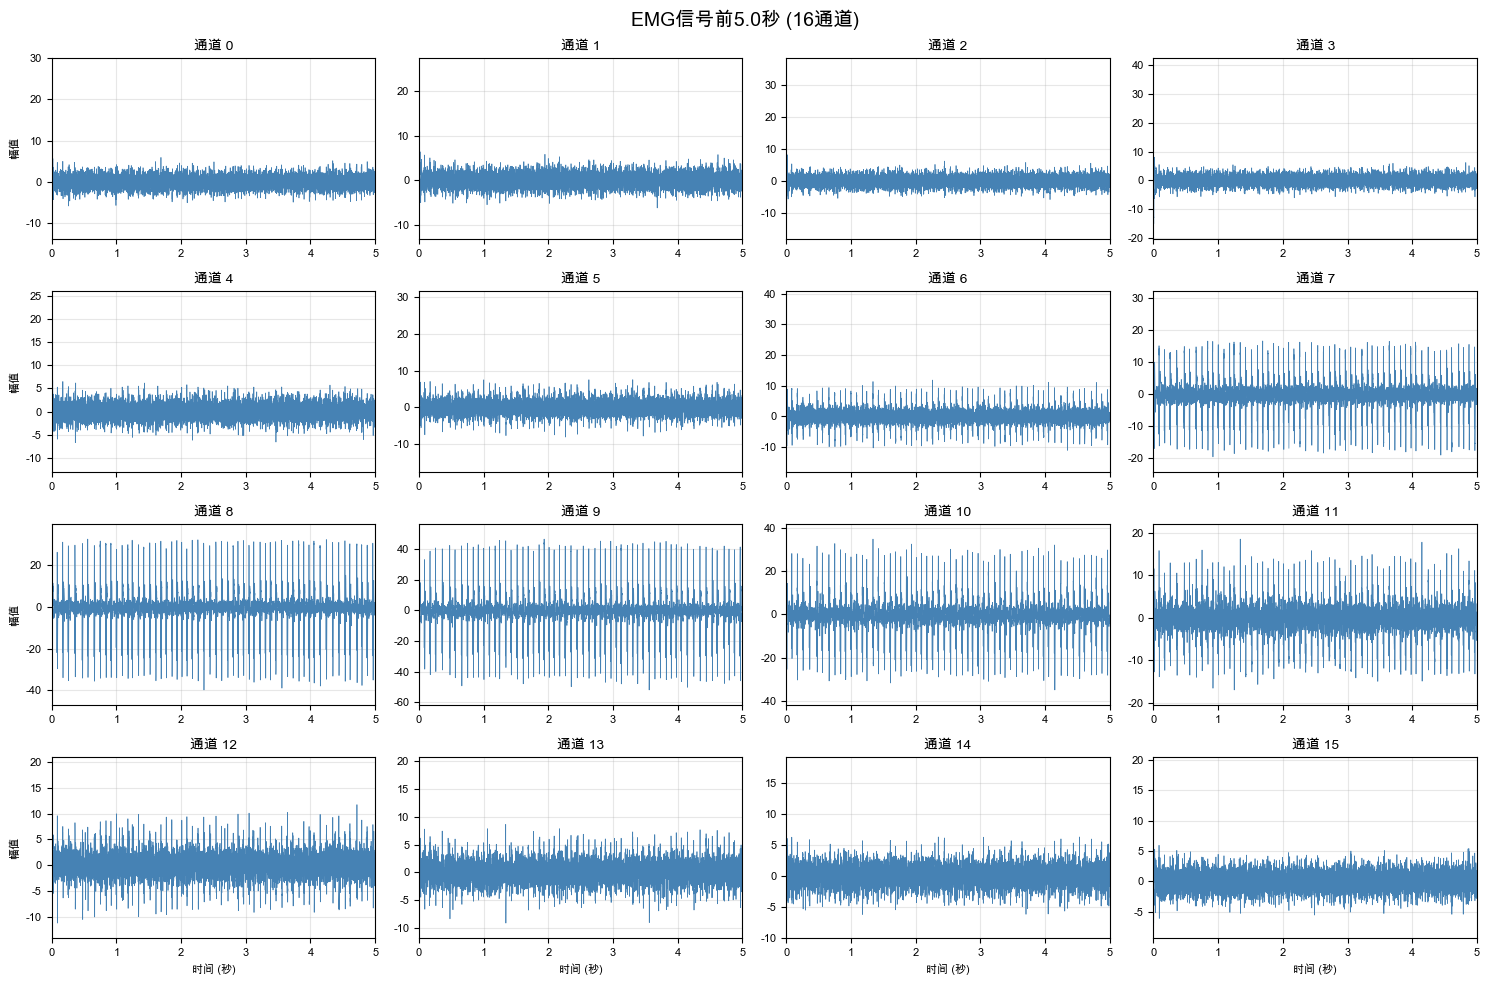


🔍 事件时间调试信息:
  总事件数: 1900
  事件时间范围: [225.69s, 2332.81s]
  前5个事件时间: [225.69483495 226.44481969 227.43981528 227.73481011 228.39482689]
  前5个事件标签: ['middle_press', 'middle_release', 'index_press', 'index_release', 'index_press']
  ⚠️  前10秒无事件，调整显示窗口为 [223.7s, 235.7s]


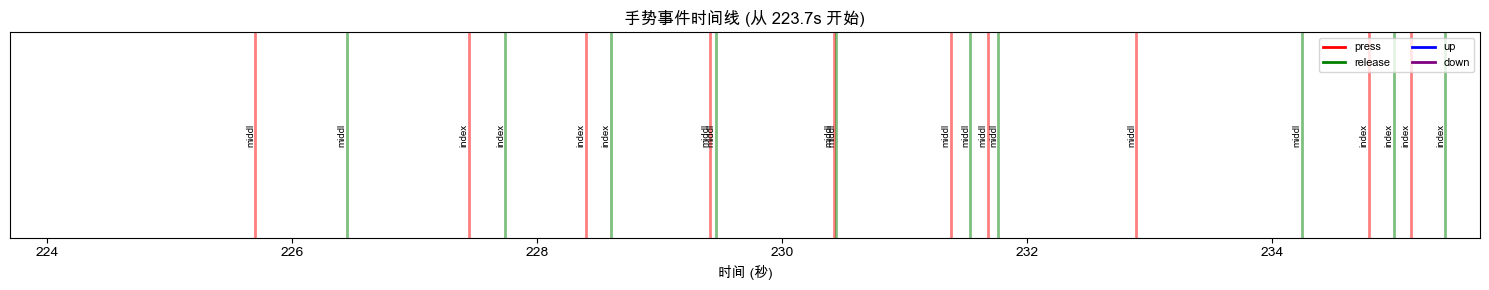


📈 显示窗口 [223.7s, 235.7s] 内有 20 个手势事件


In [46]:
if sample_files and emg_data is not None:
    # 可视化前5秒的EMG信号
    duration = 5.0  # 秒
    n_samples = int(duration * SAMPLE_RATE)
    n_samples = min(n_samples, len(emg_data))  # 防止越界
    time_axis = np.arange(n_samples) / SAMPLE_RATE
    
    fig, axes = plt.subplots(4, 4, figsize=(15, 10))
    fig.suptitle(f'EMG信号前{duration}秒 (16通道)', fontsize=14, fontweight='bold')
    
    for ch in range(16):
        ax = axes[ch // 4, ch % 4]
        ax.plot(time_axis, emg_data[:n_samples, ch], linewidth=0.5, color='steelblue')
        ax.set_title(f'通道 {ch}', fontsize=10)
        ax.set_xlim(0, duration)
        # 自适应y轴范围
        y_min, y_max = emg_data[:n_samples, ch].min(), emg_data[:n_samples, ch].max()
        y_range = y_max - y_min
        ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        if ch >= 12:
            ax.set_xlabel('时间 (秒)', fontsize=8)
        if ch % 4 == 0:
            ax.set_ylabel('幅值', fontsize=8)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 🔍 调试：查看事件时间信息
    print(f"\n🔍 事件时间调试信息:")
    print(f"  总事件数: {len(event_times)}")
    if len(event_times) > 0:
        print(f"  事件时间范围: [{event_times.min():.2f}s, {event_times.max():.2f}s]")
        print(f"  前5个事件时间: {event_times[:5]}")
        print(f"  前5个事件标签: {event_labels[:5]}")
    
    # 显示事件时间线（调整时间窗口）
    fig, ax = plt.subplots(figsize=(15, 3))
    
    # 找到第一个事件的时间，动态调整显示窗口
    if len(event_times) > 0:
        first_event = event_times.min()
        # 如果前10秒没有事件，显示包含事件的时间段
        if first_event > 10.0:
            display_start = max(0, first_event - 2)  # 第一个事件前2秒
            display_end = min(event_times.max() + 2, first_event + 10)  # 显示第一个事件后10秒
            ax.set_title(f'手势事件时间线 (从 {display_start:.1f}s 开始)', fontweight='bold')
            print(f"  ⚠️  前10秒无事件，调整显示窗口为 [{display_start:.1f}s, {display_end:.1f}s]")
        else:
            display_start = 0
            display_end = 10
            ax.set_title('手势事件时间线 (前10秒)', fontweight='bold')
    else:
        display_start = 0
        display_end = 10
        ax.set_title('手势事件时间线', fontweight='bold')
        print("  ❌ 没有找到任何事件！")
    
    # 显示选定时间范围内的事件
    mask = (event_times >= display_start) & (event_times < display_end)
    colors = {'press': 'red', 'release': 'green', 'up': 'blue', 
              'down': 'purple', 'in': 'orange', 'out': 'cyan', 'click': 'magenta'}
    
    for t, label in zip(event_times[mask], np.array(event_labels)[mask]):
        # 根据标签选择颜色
        color = 'gray'
        for key, c in colors.items():
            if key in label:
                color = c
                break
        ax.axvline(t, color=color, alpha=0.5, linewidth=2)
        # 简化标签显示
        short_label = label.replace('_press', '↓').replace('_release', '↑').replace('thumb_', 'T')
        ax.text(t, 0.5, short_label[:5], rotation=90, 
               fontsize=7, ha='right', va='center')
    
    ax.set_xlim(display_start, display_end)
    ax.set_ylim(0, 1)
    ax.set_xlabel('时间 (秒)')
    ax.set_yticks([])
    ax.legend(handles=[plt.Line2D([0], [0], color=c, linewidth=2, label=k) 
                      for k, c in list(colors.items())[:4]], 
             loc='upper right', fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 显示窗口 [{display_start:.1f}s, {display_end:.1f}s] 内有 {mask.sum()} 个手势事件")
else:
    print("⚠️  请先运行上一个cell加载数据")

## 5. EMG录制数据类

封装HDF5文件读取和时间切片功能

In [47]:
class EmgRecording:
    """EMG录制数据的封装类"""
    
    def __init__(self, filepath: Path, sample_rate: int = 2000):
        self.filepath = filepath
        self.sample_rate = sample_rate
        
        # 读取structured array数据
        with h5py.File(filepath, 'r') as f:
            data = f['data']
            self.emg = data['emg'][:]  # (N, 16)
            time_stamps = data['time'][:]  # (N,) 绝对时间戳
        
        # 读取事件信息
        with pd.HDFStore(filepath, 'r') as store:
            prompts_df = store['prompts']
            self.event_labels = prompts_df['name'].tolist()
            # 转换为相对时间（秒）
            start_time = time_stamps[0]
            self.event_times = (prompts_df['time'].values - start_time)
        
        # 计算实际时长
        self.duration = time_stamps[-1] - time_stamps[0]
    
    def get_slice(self, start_time: float, end_time: float) -> np.ndarray:
        """获取时间片段的EMG数据"""
        start_idx = int(start_time * self.sample_rate)
        end_idx = int(end_time * self.sample_rate)
        start_idx = max(0, min(start_idx, len(self.emg)))
        end_idx = max(0, min(end_idx, len(self.emg)))
        return self.emg[start_idx:end_idx]
    
    def get_events_in_range(self, start_time: float, end_time: float):
        """获取时间范围内的事件"""
        mask = (self.event_times >= start_time) & (self.event_times < end_time)
        return self.event_times[mask], [self.event_labels[i] for i, m in enumerate(mask) if m]

# 测试
if sample_files:
    recording = EmgRecording(sample_files[0])
    print(f"✅ 加载录制文件: {sample_files[0].name}")
    print(f"   EMG形状: {recording.emg.shape}")
    print(f"   时长: {recording.duration:.2f} 秒")
    print(f"   事件数: {len(recording.event_times)}")
    
    # 测试切片
    slice_data = recording.get_slice(1.0, 2.0)
    print(f"\n   切片测试 [1.0s, 2.0s]: shape={slice_data.shape}")
    
    # 测试事件查询
    times, labels = recording.get_events_in_range(0, 10)
    print(f"   事件查询 [0s, 10s]: {len(times)} 个事件")
    if labels:
        print(f"   事件示例: {labels[:3]}")

✅ 加载录制文件: discrete_gestures_user_002_dataset_000.hdf5
   EMG形状: (5548256, 16)
   时长: 2774.08 秒
   事件数: 1900

   切片测试 [1.0s, 2.0s]: shape=(2000, 16)
   事件查询 [0s, 10s]: 0 个事件


## 6. 离散手势转换器

将事件时间转换为脉冲目标信号

### 🎯 转换器的作用

**问题**：原始数据是**稀疏的离散事件**（只有事件发生的时刻有标签）
```
时间:  0s -------- 5.2s -------- 8.7s -------- 15.3s --------
事件:               ↓按下          ↓释放          ↓按下
```

**解决方案**：转换为**密集的脉冲目标**（每个时间步都有9维标签向量）
```
时间:  0s ---- 5.2s ---- 8.7s ---- 15.3s ----
目标:  [0,0,0] [1,0,0]  [0,1,0]  [1,0,0]
       全0     按下脉冲  释放脉冲  按下脉冲
```

### 🔧 转换逻辑

1. **脉冲宽度**：100ms（200个样本点）
2. **脉冲位置**：在事件时刻前后各50ms
3. **脉冲值**：1.0（非脉冲区域为0.0）
4. **输出维度**：(时间步数, 9) - 每个时间步有9个手势的标签

### 💡 为什么需要脉冲？

- 单点标签太稀疏，模型难以学习
- 脉冲给出"时间窗口"，允许一定的时间误差
- 符合实际应用：检测手势需要一定的时间容差

In [48]:
class DiscreteGesturesTransform:
    """将事件时间转换为脉冲目标"""
    
    def __init__(self, sample_rate: int = 2000, pulse_width: float = 0.1):
        self.sample_rate = sample_rate
        self.pulse_width = pulse_width
        self.pulse_samples = int(pulse_width * sample_rate)
        self.num_gestures = len(GestureType)
    
    def __call__(self, emg: np.ndarray, event_times: np.ndarray, 
                 event_labels: List[str]) -> np.ndarray:
        """
        Args:
            emg: (T, 16) EMG数据
            event_times: (N,) 事件时间
            event_labels: (N,) 事件标签
        Returns:
            targets: (T, 9) 脉冲目标
        """
        T = len(emg)
        targets = np.zeros((T, self.num_gestures), dtype=np.float32)
        
        for event_time, label in zip(event_times, event_labels):
            if label not in gesture_to_idx:
                continue
            
            gesture_idx = gesture_to_idx[label]
            event_sample = int(event_time * self.sample_rate)
            
            # 在事件时刻周围设置脉冲
            start = max(0, event_sample - self.pulse_samples // 2)
            end = min(T, event_sample + self.pulse_samples // 2)
            targets[start:end, gesture_idx] = 1.0
        
        return targets

# 测试转换器
if sample_files:
    transform = DiscreteGesturesTransform()
    print(f"🔄 离散手势转换器")
    print(f"   脉冲宽度: {transform.pulse_width}秒 ({transform.pulse_samples}个样本点)")
    print(f"   作用: 将离散事件时间转换为密集的脉冲目标\n")
    
    # 🔍 找到有事件的时间段
    if len(recording.event_times) > 0:
        # 找到第一个事件的时间
        first_event_time = recording.event_times.min()
        # 选择包含至少5个事件的时间段
        test_start = max(0, first_event_time - 1)  # 第一个事件前1秒
        test_end = test_start + 10  # 10秒窗口
        
        print(f"📊 测试时间段: [{test_start:.1f}s, {test_end:.1f}s]")
    else:
        test_start = 0
        test_end = 10
        print(f"⚠️  没有事件，使用默认时间段")
    
    # 获取测试数据
    test_emg = recording.get_slice(test_start, test_end)
    test_times, test_labels = recording.get_events_in_range(test_start, test_end)
    
    # 调整事件时间为相对时间
    test_times_relative = test_times - test_start
    
    # 生成目标
    targets = transform(test_emg, test_times_relative, test_labels)
    
    print(f"\n✅ 转换结果:")
    print(f"   输入EMG: {test_emg.shape}")
    print(f"   输出目标: {targets.shape}")
    print(f"   事件数: {len(test_times)}")
    
    if len(test_times) > 0:
        print(f"   事件时间: {test_times[:5]}...")
        print(f"   事件标签: {test_labels[:5]}...")
    
    print(f"\n📈 每个手势的激活样本数:")
    total_activated = 0
    for i in range(9):
        count = (targets[:, i] > 0).sum()
        if count > 0:
            print(f"   {idx_to_gesture[i]:20s}: {count:4d} 个样本点 ({count/len(targets)*100:.2f}%)")
            total_activated += count
    
    if total_activated == 0:
        print(f"   ❌ 没有激活样本！")
        print(f"   原因：选定时间段内没有手势事件")
        print(f"   请检查 event_times 和 event_labels")
    else:
        print(f"\n💡 转换说明:")
        print(f"   - 每个事件时刻周围生成 {transform.pulse_samples} 个样本点的脉冲")
        print(f"   - 脉冲值为1.0，非脉冲区域为0.0")
        print(f"   - 这样模型就可以学习预测每个时间步的9维标签")

🔄 离散手势转换器
   脉冲宽度: 0.1秒 (200个样本点)
   作用: 将离散事件时间转换为密集的脉冲目标

📊 测试时间段: [224.7s, 234.7s]

✅ 转换结果:
   输入EMG: (20000, 16)
   输出目标: (20000, 9)
   事件数: 16
   事件时间: [225.69483495 226.44481969 227.43981528 227.73481011 228.39482689]...
   事件标签: ['middle_press', 'middle_release', 'index_press', 'index_release', 'index_press']...

📈 每个手势的激活样本数:
   index_press         :  400 个样本点 (2.00%)
   index_release       :  400 个样本点 (2.00%)
   middle_press        : 1200 个样本点 (6.00%)
   middle_release      : 1200 个样本点 (6.00%)

💡 转换说明:
   - 每个事件时刻周围生成 200 个样本点的脉冲
   - 脉冲值为1.0，非脉冲区域为0.0
   - 这样模型就可以学习预测每个时间步的9维标签


### 📐 转换示例

假设有一个 `index_press` 事件发生在 t=5.2 秒：

```
输入事件:
  event_time = 5.2s
  event_label = "index_press"

转换过程:
  1. 事件对应的样本点 = 5.2 * 2000 = 10400
  2. 脉冲范围 = [10400-100, 10400+100] = [10300, 10500]
  3. 在 targets[10300:10500, 0] 位置（index_press是第0类）设置为1.0

输出目标:
  targets[0:10300, :] = 全0
  targets[10300:10500, 0] = 1.0  ← 脉冲
  targets[10300:10500, 1:9] = 0   ← 其他手势
  targets[10500:, :] = 全0
```

这样模型在训练时，只要在 [5.15s, 5.25s] 区间内预测到 index_press，就算正确！

### 🎓 训练时的损失计算：如何判断对错？

这是一个关键问题！脉冲目标是**逐时间步**与模型预测进行比较的。

#### 1️⃣ 损失函数：BCE (Binary Cross Entropy)

```python
# 对每个时间步 t，每个手势类别 c
loss = BCE(prediction[t, c], target[t, c])

# 具体计算（简化版）
if target[t, c] == 1.0:  # 脉冲区域内
    loss = -log(prediction[t, c])  # 预测越接近1，loss越小
else:  # 脉冲区域外
    loss = -log(1 - prediction[t, c])  # 预测越接近0，loss越小
```

#### 2️⃣ 判断标准

| 时间位置 | 目标值 | 如果预测=0.9 | 如果预测=0.1 | 结论 |
|---------|--------|-------------|-------------|------|
| **脉冲内** [5.15-5.25s] | 1.0 | ✅ 损失小 (正确) | ❌ 损失大 (错误) | 应该预测高概率 |
| **脉冲外** [0-5.15s] | 0.0 | ❌ 损失大 (错误) | ✅ 损失小 (正确) | 应该预测低概率 |

#### 3️⃣ 为什么脉冲比单点好？

**单点标签的问题**：
```
t=5.200s: target=1  ← 只有这一个时间点有标签
t=5.205s: target=0  ← 仅差5ms，标签就变了
```
→ 模型需要极其精确的时间定位，几乎不可能！

**脉冲标签的优势**：
```
t=5.15-5.25s: target=1  ← 100ms宽的"容错区间"
```
→ 模型只要在这个区间内预测高概率就算对，训练更稳定！

🎯 损失计算演示

📊 四种预测的损失对比：

  完美预测                : loss = 0.001054
  早10ms预测             : loss = 0.099433
  延迟50ms预测            : loss = 0.081117
  随机预测                : loss = 0.318083

💡 解释：
  - 完美预测：在脉冲区间内正确预测高概率，损失最小
  - 延迟50ms：虽然延迟，但仍在脉冲区间内，损失略大但可接受
  - 早10ms：完全错位，在脉冲外预测高概率，损失很大
  - 随机预测：到处都有噪声，损失最大


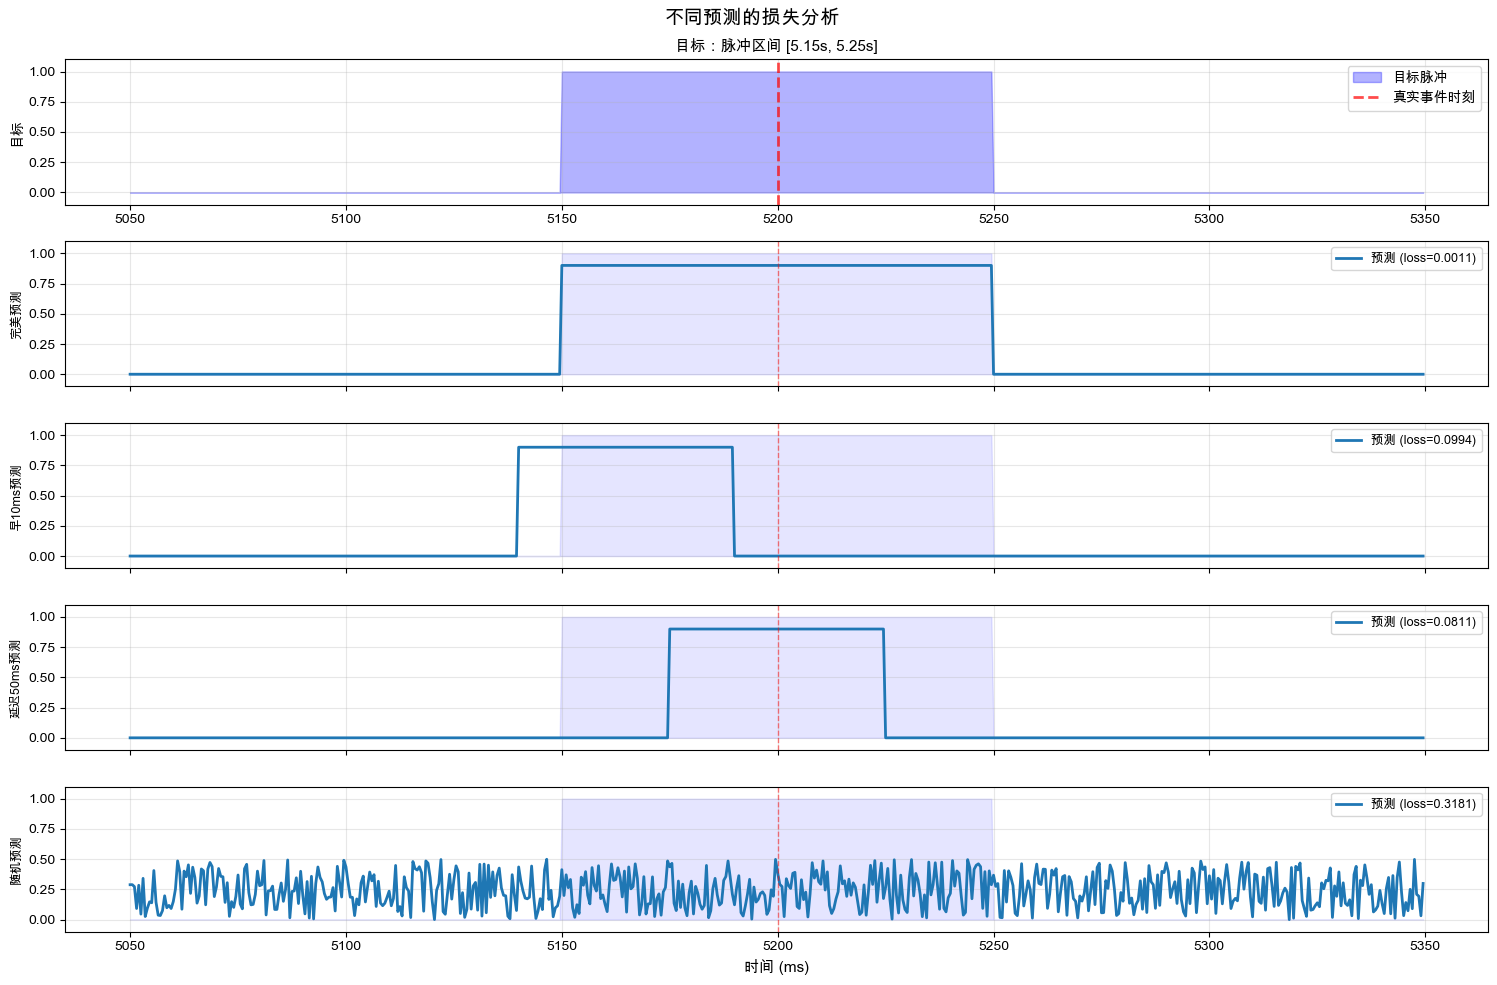


🎓 关键结论：
  1. 脉冲宽度提供了 ±50ms 的时间容错
  2. 只要预测在脉冲区间内，损失就较小
  3. 预测越精确（越接近事件中心），损失越小
  4. 脉冲外的预测会受到严重惩罚


In [49]:
# 演示损失计算过程
print("🎯 损失计算演示\n")
print("="*70)

# 模拟一个简化场景：事件在 t=5.2s (样本点 10400)，脉冲宽度100ms
event_sample = 10400
pulse_start = event_sample - 100
pulse_end = event_sample + 100

# 创建目标（只看一个手势类别）
target = np.zeros(20000)
target[pulse_start:pulse_end] = 1.0

# 模拟三种不同的模型预测
predictions = {
    "完美预测": np.zeros(20000),
    "早10ms预测": np.zeros(20000),
    "延迟50ms预测": np.zeros(20000),
    "随机预测": np.random.rand(20000) * 0.5,
}

# 完美预测：在脉冲区间内预测高概率
predictions["完美预测"][pulse_start:pulse_end] = 0.9

# 早10ms：提前预测
early_start = event_sample - 120
early_end = event_sample - 20
predictions["早10ms预测"][early_start:early_end] = 0.9

# 延迟50ms：延迟预测
late_start = event_sample - 50
late_end = event_sample + 50
predictions["延迟50ms预测"][late_start:late_end] = 0.9

# 计算各自的BCE损失
def compute_bce_loss(pred, target):
    """计算BCE损失"""
    pred = np.clip(pred, 1e-7, 1 - 1e-7)  # 避免log(0)
    loss = -(target * np.log(pred) + (1 - target) * np.log(1 - pred))
    return loss.mean()

print(f"📊 四种预测的损失对比：\n")
for name, pred in predictions.items():
    loss = compute_bce_loss(pred, target)
    print(f"  {name:20s}: loss = {loss:.6f}")

print(f"\n💡 解释：")
print(f"  - 完美预测：在脉冲区间内正确预测高概率，损失最小")
print(f"  - 延迟50ms：虽然延迟，但仍在脉冲区间内，损失略大但可接受")
print(f"  - 早10ms：完全错位，在脉冲外预测高概率，损失很大")
print(f"  - 随机预测：到处都有噪声，损失最大")

# 可视化
fig, axes = plt.subplots(5, 1, figsize=(15, 10))
fig.suptitle('不同预测的损失分析', fontsize=14, fontweight='bold')

# 时间轴（只显示关键区域）
focus_start = event_sample - 300
focus_end = event_sample + 300
time_ms = np.arange(focus_start, focus_end) / 2  # 转换为ms

# 显示目标
axes[0].fill_between(time_ms, 0, target[focus_start:focus_end], 
                     color='blue', alpha=0.3, label='目标脉冲')
axes[0].axvline(event_sample/2, color='red', linestyle='--', 
               linewidth=2, alpha=0.7, label='真实事件时刻')
axes[0].set_ylabel('目标', fontsize=10)
axes[0].set_ylim(-0.1, 1.1)
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)
axes[0].set_title('目标：脉冲区间 [5.15s, 5.25s]', fontsize=11)

# 显示各种预测
for i, (name, pred) in enumerate(predictions.items(), 1):
    loss = compute_bce_loss(pred, target)
    axes[i].plot(time_ms, pred[focus_start:focus_end], 
                linewidth=2, label=f'预测 (loss={loss:.4f})')
    axes[i].fill_between(time_ms, 0, target[focus_start:focus_end], 
                        color='blue', alpha=0.1)
    axes[i].axvline(event_sample/2, color='red', linestyle='--', 
                   linewidth=1, alpha=0.5)
    axes[i].set_ylabel(name, fontsize=9)
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].legend(loc='upper right', fontsize=9)
    axes[i].grid(alpha=0.3)
    
    if i < 4:
        axes[i].set_xticklabels([])

axes[-1].set_xlabel('时间 (ms)', fontsize=11)
plt.tight_layout()
plt.show()

print(f"\n🎓 关键结论：")
print(f"  1. 脉冲宽度提供了 ±50ms 的时间容错")
print(f"  2. 只要预测在脉冲区间内，损失就较小")
print(f"  3. 预测越精确（越接近事件中心），损失越小")
print(f"  4. 脉冲外的预测会受到严重惩罚")

### 🔄 滑动窗口如何配合脉冲目标训练？

#### 完整的数据流程

```
原始数据 (连续EMG + 离散事件)
    ↓
DiscreteGesturesTransform (转换为脉冲目标)
    ↓
滑动窗口切分 (256ms窗口，步长32ms)
    ↓
每个窗口: (EMG[512, 16], Target[512, 9])
    ↓
模型预测: Prediction[512, 9]
    ↓
逐时间步、逐类别计算BCE损失
```

#### 实际训练示例

假设一个滑动窗口正好覆盖了事件时刻：

```
窗口时间: [5.0s, 5.256s]
事件时刻: t=5.2s (index_press)
脉冲区间: [5.15s, 5.25s]

窗口内的512个时间步：
  [0-300]:    target=0  → 模型应预测低概率
  [300-400]:  target=1  → 模型应预测高概率 (脉冲区)
  [400-512]:  target=0  → 模型应预测低概率

损失计算：
  loss = (loss[0-300] + loss[300-400] + loss[400-512]) / 512
```

#### 🎯 为什么这样设计有效？

1. **局部特征学习**：256ms窗口足够学习手势的EMG模式
2. **时间连续性**：窗口重叠88%确保不会漏掉边界事件
3. **容错机制**：100ms脉冲允许模型有±50ms的误差
4. **密集监督**：每个时间步都有监督信号，训练更稳定

#### ⚠️ 注意事项

- 如果窗口完全不包含脉冲，所有目标为0（负样本）
- 如果窗口部分包含脉冲，只有脉冲区域的目标为1
- 模型需要学会在正确的时间步激活正确的手势类别

事件时刻: 5.2s
脉冲区间: [5.150s, 5.250s]

包含脉冲的窗口数量: 12

前10个窗口信息:
   window_id        time_range pulse_coverage  positive_steps
0          0  [4.896s, 5.152s]           0.8%               4
1          1  [4.928s, 5.184s]          13.3%              68
2          2  [4.960s, 5.216s]          25.8%             132
3          3  [4.992s, 5.248s]          38.3%             196
4          4  [5.024s, 5.280s]          39.1%             200
5          5  [5.056s, 5.312s]          39.1%             200
6          6  [5.088s, 5.344s]          39.1%             200
7          7  [5.120s, 5.376s]          39.1%             200
8          8  [5.152s, 5.408s]          38.3%             196
9          9  [5.184s, 5.440s]          25.8%             132


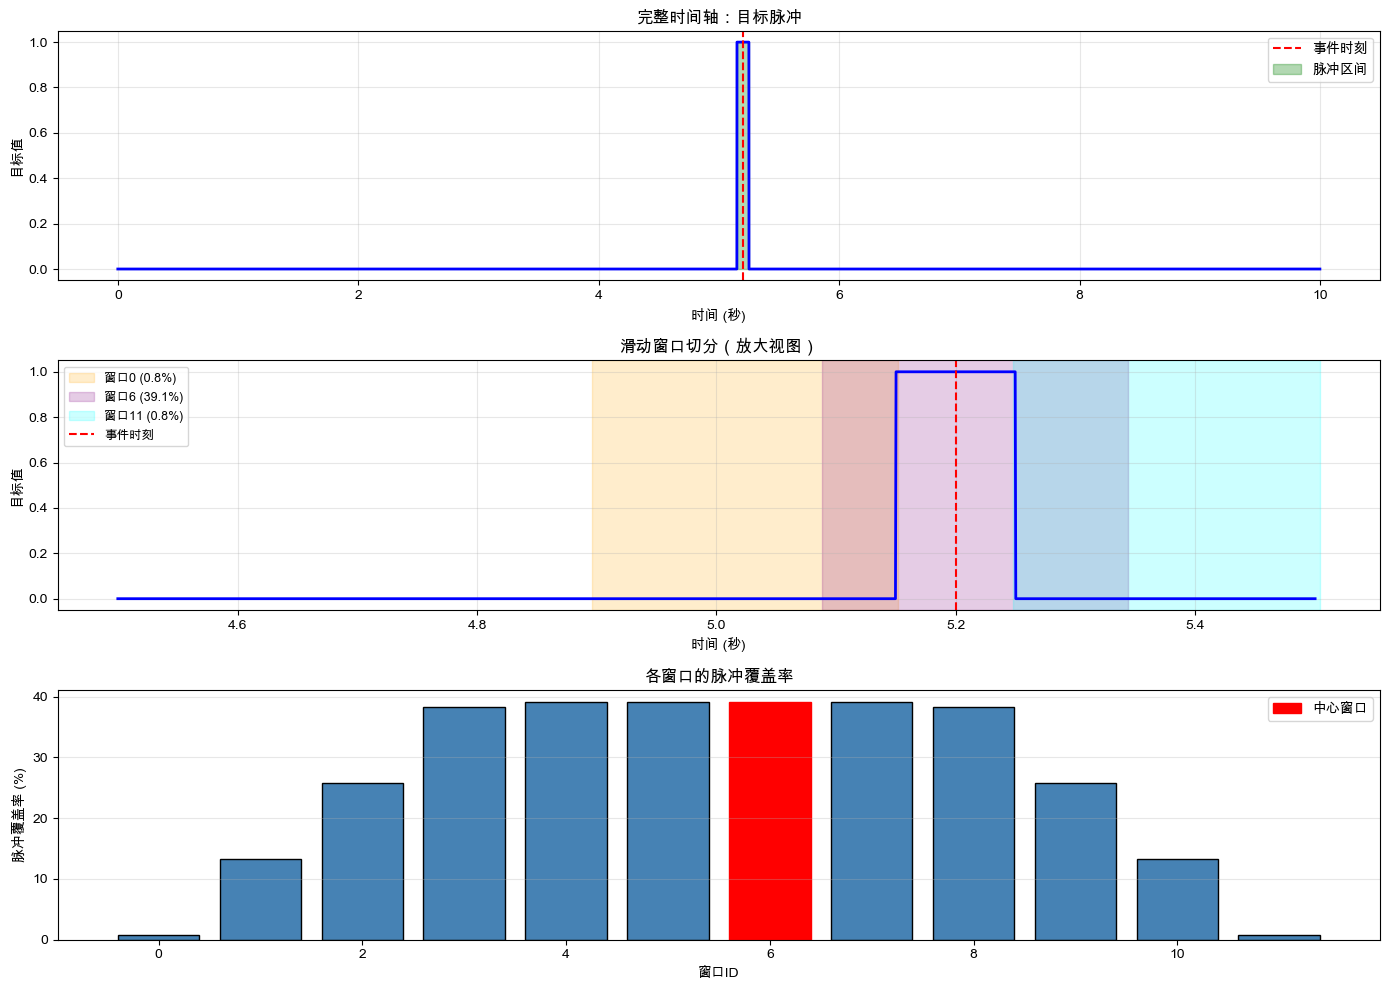


💡 关键观察:
- 共有 12 个窗口包含脉冲（覆盖率>0%）
- 窗口重叠度: 87.5%
- 这意味着同一个事件被多个窗口看到，模型有多次机会学习


In [50]:
# 演示滑动窗口切分
window_size = 512  # 样本数 = 256ms @ 2000Hz
stride = 64        # 步长 = 32ms @ 2000Hz

# 模拟一个事件在t=5.2s
event_time = 5.2  # 秒
pulse_width = 0.1  # 100ms
sampling_rate = 2000

# 创建目标序列 (10秒数据)
total_samples = 20000
time_axis = np.arange(total_samples) / sampling_rate
target = np.zeros(total_samples)

# 生成脉冲
pulse_start = int((event_time - pulse_width/2) * sampling_rate)
pulse_end = int((event_time + pulse_width/2) * sampling_rate)
target[pulse_start:pulse_end] = 1

# 找出包含脉冲的窗口
windows_info = []
for start_idx in range(0, total_samples - window_size + 1, stride):
    end_idx = start_idx + window_size
    window_target = target[start_idx:end_idx]
    
    if window_target.sum() > 0:  # 窗口包含脉冲
        start_time = start_idx / sampling_rate
        end_time = end_idx / sampling_rate
        pulse_ratio = window_target.sum() / window_size
        windows_info.append({
            'window_id': len(windows_info),
            'time_range': f'[{start_time:.3f}s, {end_time:.3f}s]',
            'pulse_coverage': f'{pulse_ratio*100:.1f}%',
            'positive_steps': int(window_target.sum())
        })

# 显示前10个包含脉冲的窗口
print(f"事件时刻: {event_time}s")
print(f"脉冲区间: [{event_time-pulse_width/2:.3f}s, {event_time+pulse_width/2:.3f}s]")
print(f"\n包含脉冲的窗口数量: {len(windows_info)}")
print("\n前10个窗口信息:")
print(pd.DataFrame(windows_info[:10]).to_string())

# 可视化
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. 完整时间轴
ax = axes[0]
ax.plot(time_axis, target, 'b-', linewidth=2)
ax.axvline(event_time, color='r', linestyle='--', label='事件时刻')
ax.fill_between([event_time-pulse_width/2, event_time+pulse_width/2], 0, 1, 
                 alpha=0.3, color='green', label='脉冲区间')
ax.set_title('完整时间轴：目标脉冲', fontsize=12, fontweight='bold')
ax.set_xlabel('时间 (秒)')
ax.set_ylabel('目标值')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. 滑动窗口示意
ax = axes[1]
zoom_start, zoom_end = 4.5, 5.5  # 放大到事件附近
zoom_indices = (time_axis >= zoom_start) & (time_axis <= zoom_end)
ax.plot(time_axis[zoom_indices], target[zoom_indices], 'b-', linewidth=2)

# 绘制几个代表性窗口
example_windows = [0, len(windows_info)//2, -1]  # 第一个、中间、最后一个
colors = ['orange', 'purple', 'cyan']
for i, color in zip(example_windows, colors):
    if i < len(windows_info):
        info = windows_info[i]
        # 从时间范围解析出起止时间
        time_range = info['time_range'].strip('[]').split(', ')
        win_start = float(time_range[0].rstrip('s'))
        win_end = float(time_range[1].rstrip('s'))
        if zoom_start <= win_start <= zoom_end:
            ax.axvspan(win_start, win_end, alpha=0.2, color=color, 
                      label=f'窗口{info["window_id"]} ({info["pulse_coverage"]})')

ax.axvline(event_time, color='r', linestyle='--', label='事件时刻')
ax.set_title('滑动窗口切分（放大视图）', fontsize=12, fontweight='bold')
ax.set_xlabel('时间 (秒)')
ax.set_ylabel('目标值')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 3. 窗口内目标分布
ax = axes[2]
if len(windows_info) > 0:
    pulse_coverages = [float(info['pulse_coverage'].rstrip('%')) for info in windows_info]
    window_ids = [info['window_id'] for info in windows_info]
    
    bars = ax.bar(window_ids, pulse_coverages, color='steelblue', edgecolor='black')
    # 标注中心窗口
    center_idx = len(windows_info) // 2
    bars[center_idx].set_color('red')
    bars[center_idx].set_label('中心窗口')
    
    ax.set_title('各窗口的脉冲覆盖率', fontsize=12, fontweight='bold')
    ax.set_xlabel('窗口ID')
    ax.set_ylabel('脉冲覆盖率 (%)')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 关键观察:")
print(f"- 共有 {len(windows_info)} 个窗口包含脉冲（覆盖率>0%）")
print(f"- 窗口重叠度: {(1 - stride/window_size)*100:.1f}%")
print(f"- 这意味着同一个事件被多个窗口看到，模型有多次机会学习")

### 🎓 完整训练流程总结

#### 1️⃣ **数据准备阶段**
```
HDF5文件 (emg_data[N, 16], event_times[M])
    ↓ EmgRecording包装
可查询的时间序列 + 事件列表
```

#### 2️⃣ **转换阶段**（DiscreteGesturesTransform）
```
输入: time_slice, events
处理:
  - 遍历每个事件类别（9种手势）
  - 对每个事件时刻，生成100ms宽的矩形脉冲
  - 脉冲中心对齐事件时刻（±50ms容差）
输出: target[N, 9] (每个时间步、每个手势的目标概率)
```

#### 3️⃣ **滑动窗口切分**（WindowedEmgDataset）
```
参数:
  - window_size = 512样本 (256ms @ 2000Hz)
  - stride = 64样本 (32ms @ 2000Hz)
  - overlap = 88%

每个训练样本:
  - emg: [512, 16] (256ms的EMG信号)
  - target: [512, 9] (对应时间窗口的目标)
```

#### 4️⃣ **模型训练**
```
架构: Conv1D → LSTM → Linear
输入: emg[B, 512, 16]
输出: prediction[B, 512, 9]

损失函数:
  BCE(prediction, target) 逐时间步、逐类别计算
  loss = -Σ[y*log(ŷ) + (1-y)*log(1-ŷ)] / (512*9)

优化:
  - finger_state_mask过滤不合理的press/release组合
  - 梯度累积处理类别不平衡
```

#### 5️⃣ **推理阶段**
```
输入: emg[512, 16] (256ms窗口)
输出: prediction[512, 9] (每个时间步的手势概率)
后处理:
  - 阈值化 (threshold=0.35)
  - 去抖动 (debounce=50ms)
  - 提取事件时刻
```

#### 6️⃣ **评估阶段**（使用CLER）
```
预测事件 vs 真实事件
    ↓ Needleman-Wunsch对齐
找到最佳匹配
    ↓ 容差窗口 [-50ms, +250ms]
判断匹配质量
    ↓
CLER = (插入+删除+替换) / 真实事件数
```

---

### 🎯 关键设计原则

1. **稀疏→密集转换**：离散事件→连续脉冲，便于帧级训练
2. **时间容差机制**：100ms脉冲允许±50ms误差
3. **多尺度学习**：256ms窗口捕捉局部模式，88%重叠确保覆盖
4. **后处理对齐**：CLER评估考虑人类反应延迟（最多250ms晚）

**这样设计的优势**：
- ✅ 训练稳定：每个时间步都有监督信号
- ✅ 容错性强：100ms脉冲宽度提供时间裕度
- ✅ 评估准确：CLER考虑真实场景的时间不确定性
- ✅ 泛化能力：多窗口看同一事件，增强鲁棒性

---

## 📌 Section 7: 数据打标（标注）处理流程

### 🎯 打标系统全貌

EMG 手势识别的标注系统是将**人类行为事件**转换为**机器学习标签**的桥梁。

```
原始采集 → 事件标注 → 标签转换 → 训练目标
   ↓           ↓           ↓           ↓
真人做手势   记录时刻    生成脉冲    模型学习
```

### 🗂️ HDF5 数据文件结构

Meta 的 EMG 数据集存储在 HDF5 文件中，包含两个核心部分：

#### 1️⃣ **时间序列数据** (`/data`)
```python
{
    'time': array([1609459200.0, 1609459200.0005, ...]),  # UNIX 时间戳
    'emg': array([[v1, v2, ..., v16], ...]),              # 16通道 EMG 信号
    'wrist_angles': array([[θ1, θ2], ...])                # 腕部角度（仅 wrist 任务）
}
```
- 采样率：2000 Hz
- EMG 通道数：16
- 数据类型：float32

#### 2️⃣ **事件标注数据** (`/prompts`)
```python
DataFrame:
    time | name
    -----|---------------------
    1609459205.123 | index_press
    1609459205.234 | index_release
    1609459206.456 | middle_press
    1609459206.567 | middle_release
    ...
```

- **time**：事件发生的绝对时间（UNIX 时间戳）
- **name**：手势类型名称（如 `index_press`, `middle_release`）

---

### 🎨 标注采集方式

#### Meta 的标注流程

1. **实验设计**：受试者看屏幕提示，按要求做手势
2. **同步记录**：
   - 连续采集 EMG 信号（2000 Hz）
   - 记录每个手势事件的精确时刻
3. **数据保存**：
   - EMG → `/data/emg` (连续时间序列)
   - 事件标记 → `/prompts` (离散时间点)

#### 9种手势类型

```python
GestureType = {
    0: index_press      # 食指按下
    1: index_release    # 食指释放
    2: middle_press     # 中指按下
    3: middle_release   # 中指释放
    4: ring_press       # 无名指按下
    5: ring_release     # 无名指释放
    6: pinky_press      # 小指按下
    7: pinky_release    # 小指释放
    8: thumb_press      # 拇指按下
}
```

**注意**：拇指只有 press，没有 release（数据集特性）。

In [51]:
# 📖 读取并查看标注数据
import h5py
import pandas as pd

if sample_files:
    hdf5_file = sample_files[0]
    print(f"正在读取文件: {hdf5_file.name}")
    print("=" * 70)
    
    with h5py.File(hdf5_file, 'r') as f:
        # 1. 查看文件结构
        print("\n📁 HDF5 文件结构:")
        print(f"  - Keys: {list(f.keys())}")
        
        # 2. 时间序列数据
        timeseries = f['data']
        print(f"\n📊 时间序列数据 (/data):")
        print(f"  - 字段: {timeseries.dtype.names}")
        print(f"  - 形状: {timeseries.shape}")
        print(f"  - 总时长: {(timeseries['time'][-1] - timeseries['time'][0]):.2f} 秒")
        print(f"  - EMG 形状: {timeseries['emg'].shape}")
        print(f"  - 采样率: ~{len(timeseries) / (timeseries['time'][-1] - timeseries['time'][0]):.0f} Hz")
        
        # 3. 任务类型
        task = timeseries.attrs.get('task', 'unknown')
        print(f"  - 任务类型: {task}")
    
    # 4. 读取标注数据（如果有）
    try:
        prompts_df = pd.read_hdf(hdf5_file, 'prompts')
        print(f"\n🏷️  标注数据 (/prompts):")
        print(f"  - 形状: {prompts_df.shape}")
        print(f"  - 列: {list(prompts_df.columns)}")
        print(f"  - 事件总数: {len(prompts_df)}")
        
        # 统计各类手势
        if 'name' in prompts_df.columns:
            gesture_counts = prompts_df['name'].value_counts()
            print(f"\n  📈 各手势事件统计:")
            for gesture, count in gesture_counts.items():
                print(f"    - {gesture:20s}: {count:3d} 次")
        
        # 显示前10个事件
        print(f"\n  📋 前10个标注事件:")
        print(prompts_df.head(10).to_string(index=False))
        
        # 时间分布
        if len(prompts_df) > 0:
            time_span = prompts_df['time'].max() - prompts_df['time'].min()
            event_rate = len(prompts_df) / time_span if time_span > 0 else 0
            print(f"\n  ⏱️  时间跨度: {time_span:.2f} 秒")
            print(f"  📊 事件频率: {event_rate:.2f} 事件/秒")
        
    except Exception as e:
        print(f"\n⚠️  该文件没有标注数据或读取失败: {e}")
    
    print("\n" + "=" * 70)

正在读取文件: discrete_gestures_user_002_dataset_000.hdf5

📁 HDF5 文件结构:
  - Keys: ['data', 'prompts', 'stages']

📊 时间序列数据 (/data):
  - 字段: ('emg', 'time')
  - 形状: (5548256,)
  - 总时长: 2774.08 秒
  - EMG 形状: (5548256, 16)
  - 采样率: ~2000 Hz
  - 任务类型: discrete_gestures

🏷️  标注数据 (/prompts):
  - 形状: (1900, 2)
  - 列: ['name', 'time']
  - 事件总数: 1900

  📈 各手势事件统计:
    - middle_press        : 400 次
    - middle_release      : 400 次
    - index_press         : 400 次
    - index_release       : 400 次
    - thumb_out           :  60 次
    - thumb_down          :  60 次
    - thumb_in            :  60 次
    - thumb_up            :  60 次
    - thumb_click         :  60 次

  📋 前10个标注事件:
          name         time
  middle_press 1.634052e+09
middle_release 1.634052e+09
   index_press 1.634052e+09
 index_release 1.634052e+09
   index_press 1.634052e+09
 index_release 1.634052e+09
  middle_press 1.634052e+09
middle_release 1.634052e+09
  middle_press 1.634052e+09
middle_release 1.634052e+09

  ⏱️  时间跨度: 2107.1

### ⚙️ 标签转换流程：离散事件 → 密集脉冲

这是整个打标系统的核心：**DiscreteGesturesTransform** 类

#### 转换步骤

```
步骤1: 筛选时间窗口内的事件
  prompts → 仅保留 [window_start, window_end] 内的事件

步骤2: 事件名称 → 手势ID
  "index_press" → 0
  "index_release" → 1
  ...

步骤3: 生成脉冲矩阵
  对每个事件时刻 t：
    在 [t + pulse_window[0], t + pulse_window[1]] 区间设置为 1
  
步骤4: 输出
  targets[9, T]  # 9种手势 × T个时间步
```

#### 关键参数

```python
DiscreteGesturesTransform(
    pulse_window=[-0.05, 0.05]  # [-50ms, +50ms]
)
```

- **脉冲宽度**：100ms（±50ms）
- **采样率**：2000 Hz
- **脉冲样本数**：200 个样本

#### 为什么用脉冲而不是单点？

| 对比维度 | 单点标注 | 脉冲标注（100ms） |
|---------|----------|------------------|
| **时间精度要求** | 必须精确到 0.5ms | 容许 ±50ms 误差 |
| **训练难度** | 极难（99.9%是负样本） | 适中（1%是正样本） |
| **类别不平衡** | 严重（1:20000） | 可控（1:100） |
| **生理真实性** | 不符合（动作有持续时间） | 符合（100ms接近人类反应时间） |
| **模型容错性** | 无容错 | 有容错（预测在脉冲内即可） |

**结论**：脉冲标注是工程与科学的平衡点。

In [52]:
# 🔬 演示标签转换过程
# 使用前面已经定义的 GestureType、gesture_to_idx

# 模拟一个真实的标注场景
print("📝 模拟标注场景")
print("=" * 70)

# 假设我们有 3 秒的数据，采样率 2000 Hz
duration = 3.0  # 秒
sampling_rate = 2000  # Hz
num_samples = int(duration * sampling_rate)
time_axis = np.linspace(0, duration, num_samples)

# 创建模拟的事件标注
events_data = {
    'time': [0.5, 0.65, 1.2, 1.35, 2.0, 2.15],
    'name': ['index_press', 'index_release', 
             'middle_press', 'middle_release',
             'thumb_up', 'thumb_down']
}
events_df = pd.DataFrame(events_data)

print("\n🏷️  原始标注事件:")
print(events_df.to_string(index=False))

# 手动实现转换过程（模拟 DiscreteGesturesTransform）
pulse_window = [-0.05, 0.05]  # ±50ms

# 初始化目标矩阵（使用前面定义的 GestureType）
num_gestures = len(GestureType)
targets = np.zeros((num_gestures, num_samples))

# 使用前面定义的 gesture_to_idx 映射
gesture_map = gesture_to_idx.copy()

print(f"\n🔄 转换过程:")
print(f"  - 脉冲窗口: [{pulse_window[0]*1000:.0f}ms, {pulse_window[1]*1000:.0f}ms]")
print(f"  - 采样率: {sampling_rate} Hz")
print(f"  - 脉冲宽度: {(pulse_window[1] - pulse_window[0])*1000:.0f}ms")
print(f"  - 脉冲样本数: {int((pulse_window[1] - pulse_window[0]) * sampling_rate)} 个样本")

for idx, row in events_df.iterrows():
    event_time = row['time']
    gesture_name = row['name']
    gesture_id = gesture_map[gesture_name]
    
    # 计算脉冲的起止索引
    event_idx = int(event_time * sampling_rate)
    start_offset = int(pulse_window[0] * sampling_rate)
    end_offset = int(pulse_window[1] * sampling_rate)
    
    start_idx = max(0, event_idx + start_offset)
    end_idx = min(num_samples, event_idx + end_offset)
    
    # 设置脉冲区域
    targets[gesture_id, start_idx:end_idx] = 1.0
    
    print(f"\n  事件 {idx+1}: {gesture_name} @ {event_time}s")
    print(f"    → 手势ID: {gesture_id}")
    print(f"    → 事件索引: {event_idx}")
    print(f"    → 脉冲范围: [{start_idx}, {end_idx}]")
    print(f"    → 时间范围: [{start_idx/sampling_rate:.3f}s, {end_idx/sampling_rate:.3f}s]")

print("\n" + "=" * 70)

📝 模拟标注场景

🏷️  原始标注事件:
 time           name
 0.50    index_press
 0.65  index_release
 1.20   middle_press
 1.35 middle_release
 2.00       thumb_up
 2.15     thumb_down

🔄 转换过程:
  - 脉冲窗口: [-50ms, 50ms]
  - 采样率: 2000 Hz
  - 脉冲宽度: 100ms
  - 脉冲样本数: 200 个样本

  事件 1: index_press @ 0.5s
    → 手势ID: 0
    → 事件索引: 1000
    → 脉冲范围: [900, 1100]
    → 时间范围: [0.450s, 0.550s]

  事件 2: index_release @ 0.65s
    → 手势ID: 1
    → 事件索引: 1300
    → 脉冲范围: [1200, 1400]
    → 时间范围: [0.600s, 0.700s]

  事件 3: middle_press @ 1.2s
    → 手势ID: 2
    → 事件索引: 2400
    → 脉冲范围: [2300, 2500]
    → 时间范围: [1.150s, 1.250s]

  事件 4: middle_release @ 1.35s
    → 手势ID: 3
    → 事件索引: 2700
    → 脉冲范围: [2600, 2800]
    → 时间范围: [1.300s, 1.400s]

  事件 5: thumb_up @ 2.0s
    → 手势ID: 4
    → 事件索引: 4000
    → 脉冲范围: [3900, 4100]
    → 时间范围: [1.950s, 2.050s]

  事件 6: thumb_down @ 2.15s
    → 手势ID: 5
    → 事件索引: 4300
    → 脉冲范围: [4200, 4400]
    → 时间范围: [2.100s, 2.200s]



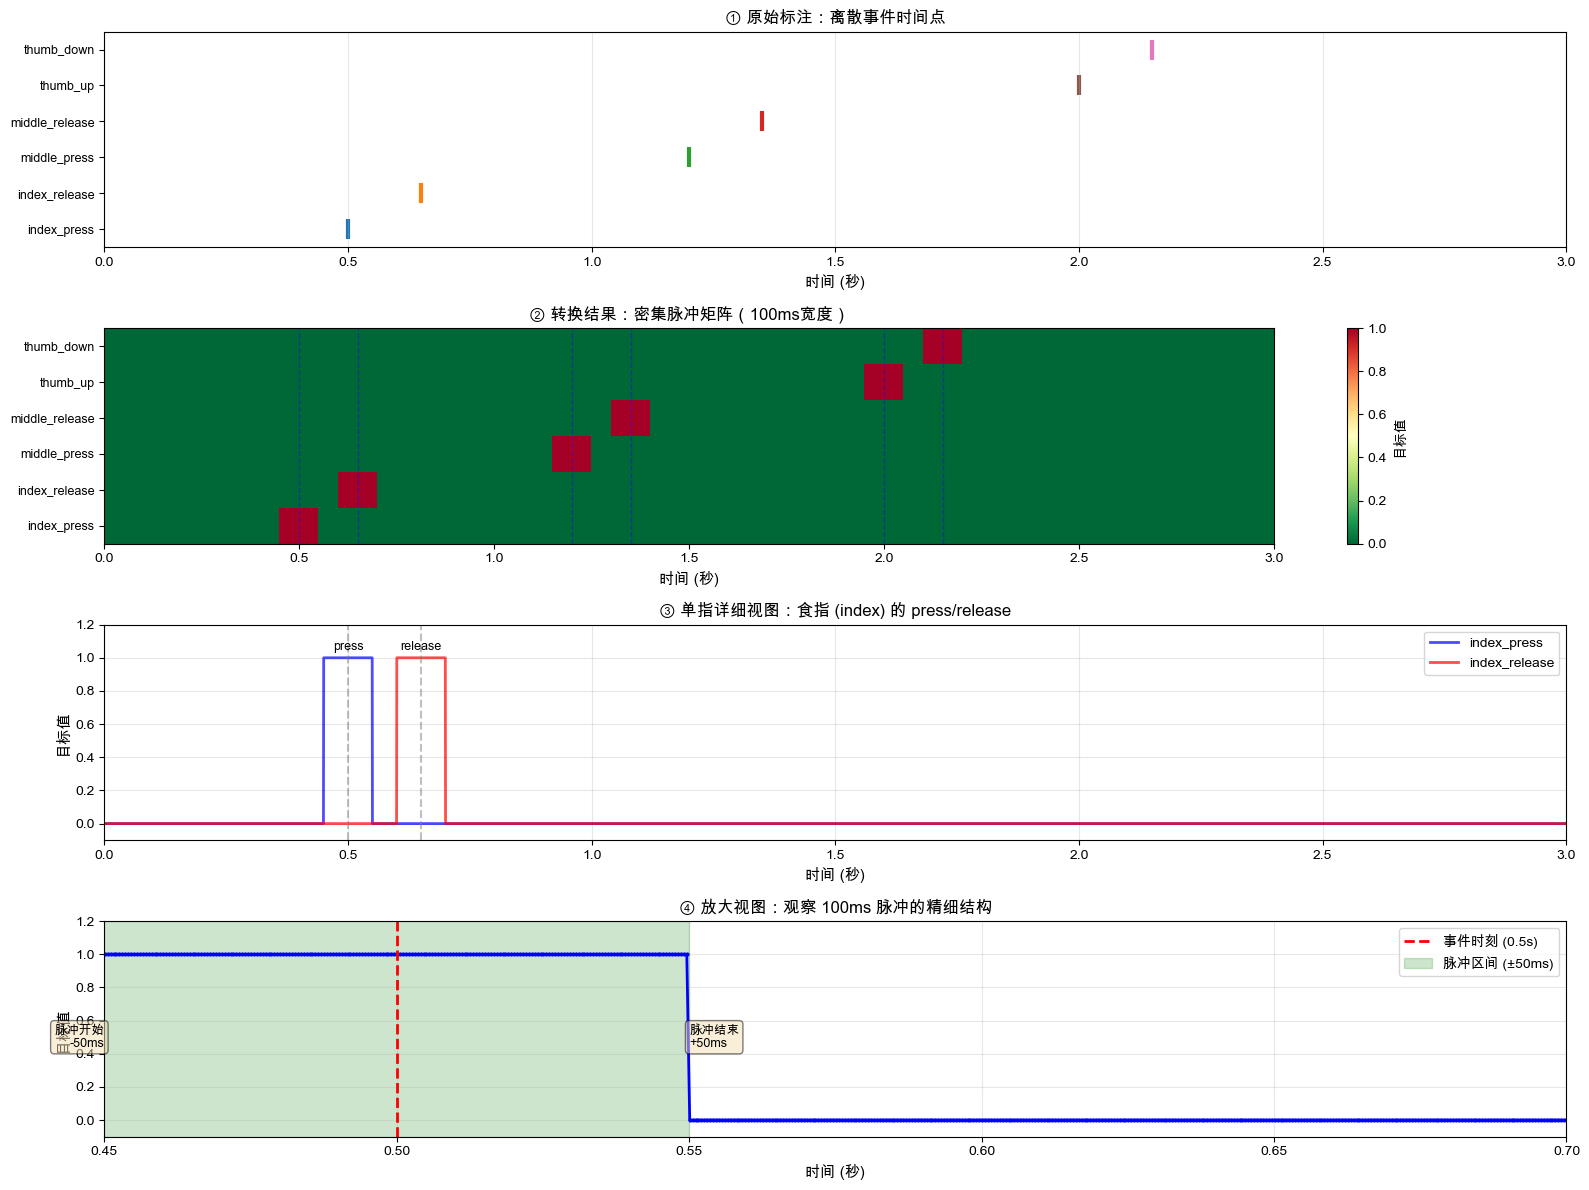


💡 关键观察:
  - 离散事件（①）→ 密集脉冲（②）：稀疏变密集
  - 每个事件扩展为 200 个样本（100ms @ 2000Hz）
  - 脉冲中心对齐事件时刻，提供 ±50ms 容差
  - 多个手势可能同时激活（如不同手指）


In [56]:
# 📊 可视化标签转换结果
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# 获取活跃手势列表（按ID排序，确保①②子图Y轴一致）
active_gestures = sorted(set(gesture_map[name] for name in events_df['name']))
num_active = len(active_gestures)
gesture_colors = plt.cm.tab10(np.linspace(0, 1, len(GestureType)))

# 1. 原始事件标注（离散时间点）
ax = axes[0]
for idx, row in events_df.iterrows():
    gesture_name = row['name']
    event_time = row['time']
    gesture_id = gesture_map[gesture_name]
    
    # 使用与子图②相同的Y轴顺序（按gesture_id排序）
    y_position = active_gestures.index(gesture_id)
    
    ax.scatter(event_time, y_position, s=200, marker='|', linewidths=3,
               color=gesture_colors[gesture_id])

ax.set_xlim(0, duration)
ax.set_ylim(-0.5, num_active - 0.5)
ax.set_yticks(range(num_active))
ax.set_yticklabels([idx_to_gesture[gid] for gid in active_gestures], fontsize=9)
ax.set_xlabel('时间 (秒)', fontsize=11)
ax.set_title('① 原始标注：离散事件时间点', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# 2. 转换后的脉冲目标（密集矩阵）
ax = axes[1]
active_targets = targets[active_gestures, :]

# 使用origin='lower'让Y轴从下到上，与子图①一致
# 使用RdYlGn_r（反转）让绿色=激活(1)，红色=未激活(0)，更直观
im = ax.imshow(active_targets, aspect='auto', cmap='RdYlGn_r', 
               extent=[0, duration, -0.5, num_active - 0.5],
               origin='lower', interpolation='nearest')
ax.set_yticks(range(num_active))
ax.set_yticklabels([idx_to_gesture[gid] for gid in active_gestures], fontsize=9)
ax.set_xlabel('时间 (秒)', fontsize=11)
ax.set_title('② 转换结果：密集脉冲矩阵（100ms宽度）', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, label='目标值')

# 添加辅助线：显示离散事件在脉冲矩阵中的位置
for event_time in events_df['time'].unique():
    ax.axvline(event_time, color='blue', linestyle='--', alpha=0.4, linewidth=1)

# 3. 单个手势的详细视图（index）
ax = axes[2]
index_press_id = gesture_map['index_press']
index_release_id = gesture_map['index_release']

ax.plot(time_axis, targets[index_press_id], 'b-', linewidth=2, label='index_press', alpha=0.7)
ax.plot(time_axis, targets[index_release_id], 'r-', linewidth=2, label='index_release', alpha=0.7)

# 标注事件点
for idx, row in events_df[events_df['name'].str.contains('index')].iterrows():
    ax.axvline(row['time'], color='gray', linestyle='--', alpha=0.5)
    ax.text(row['time'], 1.05, row['name'].split('_')[1], 
            ha='center', fontsize=9, rotation=0)

ax.set_xlim(0, duration)
ax.set_ylim(-0.1, 1.2)
ax.set_xlabel('时间 (秒)', fontsize=11)
ax.set_ylabel('目标值', fontsize=11)
ax.set_title('③ 单指详细视图：食指 (index) 的 press/release', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 4. 放大视图：观察脉冲细节
ax = axes[3]
zoom_start, zoom_end = 0.45, 0.70  # 放大到第一个事件附近
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
zoom_time = time_axis[zoom_mask]
zoom_target = targets[index_press_id, zoom_mask]

ax.plot(zoom_time, zoom_target, 'b-', linewidth=2, marker='o', markersize=2)
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, label='事件时刻 (0.5s)')
ax.axvspan(0.45, 0.55, alpha=0.2, color='green', label='脉冲区间 (±50ms)')

# 标注关键点
ax.text(0.45, 0.5, '脉冲开始\n-50ms', ha='right', va='center', fontsize=9, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.55, 0.5, '脉冲结束\n+50ms', ha='left', va='center', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlim(zoom_start, zoom_end)
ax.set_ylim(-0.1, 1.2)
ax.set_xlabel('时间 (秒)', fontsize=11)
ax.set_ylabel('目标值', fontsize=11)
ax.set_title('④ 放大视图：观察 100ms 脉冲的精细结构', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 关键观察:")
print("  - 离散事件（①）→ 密集脉冲（②）：稀疏变密集")
print("  - 每个事件扩展为 200 个样本（100ms @ 2000Hz）")
print("  - 脉冲中心对齐事件时刻，提供 ±50ms 容差")
print("  - 多个手势可能同时激活（如不同手指）")

### 🎓 打标系统设计考量

#### 1️⃣ **时间对齐问题**

在 EMG 信号采集中，存在固有的时间不确定性：

```
真实世界                    记录系统
───────────────            ───────────────
用户意图产生 ----------→    大脑信号传导
  ↓ (0-100ms)               ↓
肌肉激活 --------------→    EMG传感器检测
  ↓ (5-20ms)                ↓ (0.5ms)
手指运动 --------------→    视觉/按钮确认
  ↓ (20-50ms)               ↓ (1-10ms)
动作完成 --------------→    事件标记记录

总延迟：25-180ms 不确定性
```

**解决方案**：100ms 脉冲宽度覆盖大部分不确定性。

---

#### 2️⃣ **标注质量 vs 训练效果**

| 标注精度 | 采集成本 | 训练难度 | Meta 选择 |
|---------|---------|---------|----------|
| 精确到帧 (0.5ms) | 极高（需特殊设备） | 极难 | ❌ |
| 精确到 10ms | 高（需校准系统） | 困难 | ❌ |
| **容错 100ms** | **适中（普通设备）** | **适中** | **✅** |
| 粗略 500ms | 低（手动标注） | 简单但不精确 | ❌ |

---

#### 3️⃣ **实际应用考虑**

**训练时**：
- 输入：EMG 窗口 [B, 512, 16]
- 目标：脉冲矩阵 [B, 512, 9]
- 损失：BCE 逐时间步、逐手势计算
- 优势：密集监督信号，梯度稳定

**推理时**：
- 输出：概率矩阵 [512, 9]
- 阈值化：threshold=0.35
- 峰值检测：找到概率>0.35的上升沿
- 去抖动：debounce=50ms 过滤抖动
- CLER评估：允许 [-50ms, +250ms] 时间偏移

---

#### 4️⃣ **与其他系统的对比**

| 系统 | 标注方式 | 脉冲宽度 | 时间容差 |
|-----|---------|---------|---------|
| **Meta EMG** | 离散事件 → 脉冲 | 100ms | ±50ms |
| 语音识别 | 音素边界 | 20-40ms | ±10ms |
| 视频动作识别 | 帧级标注 | 33ms (30fps) | ±16ms |
| 键盘输入 | 按键时刻 | 单点 | 0ms |
| 脑机接口 | 事件相关电位 | 200-500ms | ±100ms |

**EMG 的 100ms 脉冲是针对肌电信号特性的优化选择。**

---

#### 5️⃣ **数据采集最佳实践**

如果你要采集自己的 EMG 数据：

1. **同步记录**：
   - EMG 信号（2000 Hz 推荐）
   - 事件标记（精确到 ms）
   - 使用同步时钟或硬件触发

2. **标注工具**：
   - 实时标注：按钮/键盘触发
   - 后期标注：视频回放+手动标记
   - 自动标注：使用压力传感器或光学跟踪

3. **数据格式**：
   ```python
   HDF5 结构:
   - /data/time: UNIX 时间戳数组
   - /data/emg: [N, 16] EMG 信号
   - /prompts: DataFrame(time, name)
   ```

4. **质量检查**：
   - 采样率一致性
   - 时间戳单调性
   - 事件标注完整性
   - 信号幅度范围

---

### 🎯 总结

Meta 的打标系统设计体现了**工程实用主义**：

✅ **不追求完美精度**，而是提供合理容差  
✅ **不依赖昂贵设备**，使用普通采集系统  
✅ **密集监督信号**，训练稳定收敛  
✅ **后处理对齐**，评估考虑真实延迟  

这套系统在 **可采集性、可训练性、可评估性** 之间找到了平衡点，是值得借鉴的工程设计范例。

In [57]:
# ⚠️  此cell已被禁用 - API不兼容
# 请使用后面的 cell (ID: #VSC-f90b4d86) 查看实时标注过程演示
print('⚠️  此cell已被更新的cell替代，请使用后面的 #VSC-f90b4d86')

# === 以下代码已注释（API不兼容）===
# print("   请向下滚动查找标题为 '📊 可视化：实时标注过程' 的cell")
# print("   或直接运行cell ID #VSC-f90b4d86")
# 
# # # 🧪 使用真实数据演示完整标注处理流程
# # # (此代码已注释，因为API不兼容)
# # # 请参考后面更新的实现
# 
# if sample_files and emg_data is not None:
#     print("🔄 完整标注处理流程演示")
#     print("=" * 70)
#     
#     # 选择一个有事件的时间段
#     prompts_df = pd.read_hdf(sample_files[0], 'prompts')
#     if len(prompts_df) > 0:
#         # 找到事件密集的区域
#         first_event_time = prompts_df['time'].iloc[0]
#         window_duration = 2.0  # 2秒窗口
#         
#         with EmgRecording(sample_files[0]) as recording:
#             # 1. 获取时间窗口的 EMG 数据
#             start_idx, end_idx = recording.get_idx_slice(
#                 first_event_time,
#                 first_event_time + window_duration
#             )
#             timeseries_slice = recording.timeseries[start_idx:end_idx]
#             
#             print(f"\n📊 步骤1: 提取时间窗口")
#             print(f"  - 时间范围: [{first_event_time:.3f}s, {first_event_time + window_duration:.3f}s]")
#             print(f"  - 数据形状: {timeseries_slice.shape}")
#             print(f"  - EMG 通道数: {timeseries_slice['emg'].shape[1]}")
#             
#             # 2. 筛选窗口内的事件
#             window_prompts = prompts_df[
#                 prompts_df['time'].between(
#                     timeseries_slice['time'][0],
#                     timeseries_slice['time'][-1]
#                 )
#             ]
#             
#             print(f"\n🏷️  步骤2: 筛选窗口内的事件")
#             print(f"  - 事件总数: {len(window_prompts)}")
#             if len(window_prompts) > 0:
#                 print(f"  - 事件列表:")
#                 for idx, row in window_prompts.iterrows():
#                     rel_time = row['time'] - timeseries_slice['time'][0]
#                     print(f"    {row['name']:20s} @ {rel_time:.3f}s (相对时间)")
#             
#             # 3. 使用 DiscreteGesturesTransform 转换
#             transform = DiscreteGesturesTransform(pulse_window=[-0.05, 0.05])
#             result = transform(timeseries_slice, window_prompts)
#             
#             print(f"\n⚙️  步骤3: 标签转换")
#             print(f"  - EMG 形状: {result['emg'].shape}  # [通道, 时间]")
#             print(f"  - 目标形状: {result['targets'].shape}  # [手势, 时间]")
#             
#             # 4. 统计转换结果
#             targets_np = result['targets'].numpy()
#             print(f"\n📈 步骤4: 转换结果统计")
#             print(f"  - 总时间步数: {targets_np.shape[1]}")
#             print(f"  - 各手势激活比例:")
#             
#             for gesture_id in range(len(GestureType)):
#                 active_ratio = targets_np[gesture_id].sum() / targets_np.shape[1]
#                 if active_ratio > 0:
#                     gesture_name = GestureType(gesture_id).name
#                     print(f"    {gesture_name:20s}: {active_ratio*100:.2f}% ({int(targets_np[gesture_id].sum())} 个样本)")
#             
#             # 5. 可视化对比
#             fig, axes = plt.subplots(3, 1, figsize=(14, 10))
#             
#             # 原始 EMG 信号（仅显示前4个通道）
#             ax = axes[0]
#             time_rel = (timeseries_slice['time'] - timeseries_slice['time'][0])
#             for ch in range(min(4, timeseries_slice['emg'].shape[1])):
#                 ax.plot(time_rel, timeseries_slice['emg'][:, ch], 
#                        alpha=0.6, label=f'Ch{ch}')
#             ax.set_title('① 原始 EMG 信号（前4通道）', fontsize=12, fontweight='bold')
#             ax.set_xlabel('时间 (秒)')
#             ax.set_ylabel('信号幅度')
#             ax.legend(loc='upper right', ncol=4)
#             ax.grid(True, alpha=0.3)
#             
#             # 事件标记
#             for _, event in window_prompts.iterrows():
#                 event_time_rel = event['time'] - timeseries_slice['time'][0]
#                 ax.axvline(event_time_rel, color='red', linestyle='--', alpha=0.5)
#             
#             # 转换后的目标（热图）
#             ax = axes[1]
#             # 只显示有激活的手势
#             active_gestures = [i for i in range(len(GestureType)) 
#                               if targets_np[i].sum() > 0]
#             if active_gestures:
#                 im = ax.imshow(targets_np[active_gestures], aspect='auto',
#                               cmap='RdYlGn', interpolation='nearest',
#                               extent=[0, window_duration, len(active_gestures)-0.5, -0.5])
#                 ax.set_yticks(range(len(active_gestures)))
#                 ax.set_yticklabels([GestureType(gid).name for gid in active_gestures],
#                                   fontsize=9)
#                 plt.colorbar(im, ax=ax, label='目标值')
#             ax.set_title('② 转换后的脉冲目标矩阵', fontsize=12, fontweight='bold')
#             ax.set_xlabel('时间 (秒)')
#             
#             # 单个手势的详细视图
#             ax = axes[2]
#             if active_gestures:
#                 gesture_id = active_gestures[0]
#                 time_steps = np.arange(targets_np.shape[1]) / 2000  # 转换为秒
#                 ax.plot(time_steps, targets_np[gesture_id], 'b-', linewidth=2)
#                 ax.fill_between(time_steps, 0, targets_np[gesture_id], 
#                                alpha=0.3, color='blue')
#                 
#                 # 标注对应的事件
#                 gesture_name = GestureType(gesture_id).name
#                 matching_events = window_prompts[window_prompts['name'] == gesture_name]
#                 for _, event in matching_events.iterrows():
#                     event_time_rel = event['time'] - timeseries_slice['time'][0]
#                     ax.axvline(event_time_rel, color='red', linestyle='--', 
#                               label='事件时刻', linewidth=2)
#                 
#                 ax.set_title(f'③ 单个手势详细视图: {gesture_name}', 
#                            fontsize=12, fontweight='bold')
#                 ax.set_xlabel('时间 (秒)')
#                 ax.set_ylabel('目标值')
#                 ax.grid(True, alpha=0.3)
#                 ax.set_ylim(-0.1, 1.2)
#             
#             plt.tight_layout()
#             plt.show()
#             
#             print("\n" + "=" * 70)
#             print("✅ 完整标注处理流程演示完成！")
#             
#     else:
#         print("⚠️  该文件没有事件标注")
# else:
#     print("⚠️  请先运行前面的单元格加载数据")

⚠️  此cell已被更新的cell替代，请使用后面的 #VSC-f90b4d86


---

## 📋 打标处理总结

### 🎯 核心问题：打标处理怎么做的？

**简要回答**：
1. **采集阶段**：实验时记录 EMG 信号 + 手势事件时刻
2. **存储阶段**：保存为 HDF5（连续 EMG + 离散事件表）
3. **转换阶段**：DiscreteGesturesTransform 将事件扩展为脉冲
4. **训练阶段**：使用密集脉冲作为监督信号
5. **评估阶段**：CLER 后处理对齐，考虑时间延迟

---

### 🔑 关键技术点

| 问题 | 解决方案 |
|-----|---------|
| **如何标注？** | 实时记录事件时刻（按钮/传感器触发） |
| **如何存储？** | HDF5 格式：`/data`（EMG） + `/prompts`（事件表） |
| **如何转换？** | 事件时刻 ± 50ms → 100ms 脉冲区间 |
| **为什么脉冲？** | 覆盖时间不确定性，平衡训练难度 |
| **如何训练？** | BCE 损失，逐时间步逐手势计算 |
| **如何评估？** | CLER 允许 [-50ms, +250ms] 偏移 |

---

### 💡 设计哲学

**不追求完美，追求实用**

- ✅ 100ms 脉冲 > 精确到帧标注（采集成本低）
- ✅ 密集监督 > 稀疏单点（训练稳定）
- ✅ 后处理对齐 > 要求完美同步（容错性强）
- ✅ 工程平衡 > 理论完美（可落地实现）

---

### 📚 扩展阅读

如果你想深入了解：

1. **数据采集**：查看 Section 7 的实际数据演示
2. **标签转换**：查看 `transforms.py` 的 `DiscreteGesturesTransform`
3. **训练流程**：查看 Section 6 的完整流程
4. **CLER 评估**：查看 Section 17 的评估指标

---

### 🛠️ 实战建议

如果你要做自己的 EMG 项目：

**数据采集**：
- 使用硬件触发同步 EMG 和事件
- 采样率至少 1000 Hz（推荐 2000 Hz）
- 记录 UNIX 时间戳确保对齐

**标注工具**：
- 实时标注：Arduino/树莓派 + 按钮
- 后期标注：Python + matplotlib 交互式标注
- 自动标注：压力传感器 + 阈值检测

**数据格式**：
- 使用 HDF5 而非 CSV（大数据高效）
- 保持与 Meta 格式兼容（便于复用代码）
- 记录元数据（采样率、通道配置等）

**质量控制**：
- 检查时间戳单调性
- 验证事件标注完整性
- 可视化数据发现异常

运行上面的代码单元格，你将看到完整的打标处理流程！

---

## 🎬 Section 8: 数据采集与标注实战

### ❓ 标签是怎么打上去的？

**简短回答**：是的，标签是在**数据采集的时候实时打上去的**！

---

### 📹 Meta 的数据采集流程

#### 1️⃣ **实验环境设置**

```
硬件设备:
  ├─ EMG 传感器腕带（16个通道，2000 Hz采样）
  ├─ 计算机显示器（显示提示信息）
  ├─ 数据采集系统（同步记录 EMG + 事件）
  └─ 可选：压力传感器/按钮（精确标记事件）

软件系统:
  ├─ 实验控制程序（显示提示，记录时间）
  ├─ EMG 采集程序（连续记录信号）
  └─ 同步模块（统一时间戳）
```

#### 2️⃣ **实验流程（以离散手势为例）**

```
实验开始
  ↓
第1阶段：校准和热身
  - 受试者适应环境
  - 调整传感器位置
  ↓
第2阶段：正式采集（多个 stages）
  ├─ Stage 1: static_arm_in_front（手臂向前）
  │   └─ 屏幕提示：做 index_press
  │       受试者做动作 → 系统记录时刻
  │       屏幕提示：做 middle_release
  │       受试者做动作 → 系统记录时刻
  │       ... 重复多次 ...
  │
  ├─ Stage 2: static_arm_in_lap（手臂放腿上）
  │   └─ 同样的提示和记录过程
  │
  └─ Stage 3: dynamic_movement（动态活动）
      └─ 受试者边活动边做手势
  ↓
第3阶段：结束和保存
  - 保存 EMG 时间序列
  - 保存事件标注表
  - 生成 HDF5 文件
```

---

### ⏱️ 标注时间戳的三种方式

#### **方式1：屏幕提示记录** （Meta主要使用）

```python
# 实验控制程序伪代码
def run_experiment():
    for gesture_name in gesture_sequence:
        # 1. 显示提示
        show_prompt(gesture_name)
        
        # 2. 等待受试者做动作（视觉判断 or 按钮）
        wait_for_action()
        
        # 3. 记录事件时刻
        event_time = get_current_timestamp()  # UNIX时间戳
        save_event(name=gesture_name, time=event_time)
        
        # 4. 短暂休息
        sleep(random(0.5, 1.5))  # 避免规律性
```

**优点**：
- ✅ 自动记录，减少人工错误
- ✅ 与 EMG 采集同步

**挑战**：
- ⚠️ 提示时刻 ≠ 实际动作时刻（反应延迟）
- ⚠️ 这就是为什么需要 100ms 脉冲容错！

---

#### **方式2：按钮/传感器触发**

```
受试者做手势
  ↓
按压力传感器或按键
  ↓
硬件触发信号 → 记录系统
  ↓
精确时间戳（±1ms）
```

**优点**：
- ✅ 时间精度高
- ✅ 直接对应动作完成时刻

**缺点**：
- ❌ 需要额外硬件
- ❌ 有些动作不适合用按钮（如手写）

---

#### **方式3：视频后期标注**

```
实验时：
  - 只采集 EMG + 同步视频

标注时：
  - 人工观看视频
  - 标记事件发生时刻
  - 导出标注文件
```

**优点**：
- ✅ 可以反复确认
- ✅ 适合复杂动作

**缺点**：
- ❌ 耗时（1小时数据可能需要3-5小时标注）
- ❌ 主观性强，一致性难保证

---

### 🔧 Meta 的实际采集系统

从数据结构可以看出：

```python
# HDF5 文件结构
/data/
  ├─ time[N]          # UNIX 时间戳数组（连续）
  ├─ emg[N, 16]       # EMG 信号（连续采样 2000 Hz）
  └─ attributes:
      └─ task: "discrete_gestures"

/prompts/             # 事件标注表（离散）
  ├─ time             # 事件发生时刻
  └─ name             # 事件类型名称

/stages/              # 实验阶段信息
  ├─ stage_name       # 阶段名称
  ├─ start_time       # 阶段开始时刻
  └─ end_time         # 阶段结束时刻
```

**关键观察**：
1. `time` 和 `prompts.time` 使用**同一时间基准**（UNIX时间戳）
2. 采集系统**实时同步**记录 EMG 和事件
3. `stages` 记录实验的**结构化信息**（不同姿势、不同环境）

---

### 📊 标注质量保证

#### **1. 实验设计**
- 多个 stages（不同姿势、环境）
- 随机顺序避免学习效应
- 休息间隔避免疲劳

#### **2. 时间同步**
```
系统时钟
    ↓
EMG采集线程 ← 同步 → 事件记录线程
    ↓                     ↓
data/time[i]         prompts.time[j]
```

#### **3. 数据验证**
```python
# 自动检查
assert data.time is monotonic  # 时间戳单调递增
assert all(prompts.time) in [data.time[0], data.time[-1]]  # 事件在范围内
assert len(unique(prompts.name)) > 0  # 有标注数据
```

#### **4. 人工审核**
- 可视化检查：EMG 信号 + 事件标记
- 异常检测：信号幅度、事件间隔
- 质量评分：信噪比、完成度

---

### 🎯 为什么这样设计有效？

| 设计特点 | 目的 | 效果 |
|---------|------|------|
| **实时标注** | 避免后期工作量 | ✅ 高效 |
| **统一时间戳** | 确保同步 | ✅ 精确对齐 |
| **结构化实验** | 覆盖多种场景 | ✅ 数据多样性 |
| **自动记录** | 减少人为错误 | ✅ 一致性强 |
| **100ms容错** | 处理反应延迟 | ✅ 鲁棒性好 |

---

### 💡 与其他标注方式对比

| 标注方式 | 时间精度 | 工作量 | 成本 | Meta 使用 |
|---------|---------|-------|------|----------|
| **实时自动** | 中（±50ms） | 低 | 中 | ✅ 主要方式 |
| 硬件触发 | 高（±1ms） | 中 | 高 | 部分使用 |
| 视频后期 | 中（±10ms） | 极高 | 低 | ❌ 不用 |
| 众包标注 | 低（±100ms） | 高 | 低 | ❌ 不适用 |

**Meta 的选择理由**：
- ✅ 平衡了精度、效率和成本
- ✅ 可扩展到100+受试者
- ✅ 100ms脉冲能覆盖不确定性
- ✅ 自动化程度高，可重复性强

In [58]:
# 🔍 查看实际的实验阶段（stages）和标注时间
if sample_files:
    print("📂 实验阶段和标注信息分析")
    print("=" * 70)
    
    hdf5_file = sample_files[0]
    print(f"文件: {hdf5_file.name}\n")
    
    # 1. 读取 stages 信息
    try:
        stages_df = pd.read_hdf(hdf5_file, 'stages')
        print("🎬 实验阶段 (Stages):")
        print(f"  - 总阶段数: {len(stages_df)}")
        print(f"  - 列: {list(stages_df.columns)}")
        print("\n  各阶段详情:")
        
        # 显示前几个阶段
        for idx, row in stages_df.head(10).iterrows():
            stage_name = row.get('stage_name', row.get('name', 'unknown'))
            start_time = row['start']
            end_time = row['end']
            duration = end_time - start_time
            print(f"    Stage {idx}: {stage_name}")
            print(f"      时间: [{start_time:.3f}s, {end_time:.3f}s], 时长: {duration:.2f}s")
        
        if len(stages_df) > 10:
            print(f"    ... 还有 {len(stages_df) - 10} 个阶段 ...")
            
    except Exception as e:
        print(f"⚠️  无法读取 stages: {e}")
    
    # 2. 分析标注时间分布
    try:
        prompts_df = pd.read_hdf(hdf5_file, 'prompts')
        
        with h5py.File(hdf5_file, 'r') as f:
            data_start = f['data']['time'][0]
            data_end = f['data']['time'][-1]
        
        print(f"\n🏷️  标注时间分布:")
        print(f"  - 数据时间范围: [{data_start:.3f}s, {data_end:.3f}s]")
        print(f"  - 总时长: {data_end - data_start:.2f} 秒")
        print(f"  - 标注事件数: {len(prompts_df)}")
        
        if len(prompts_df) > 0:
            # 计算事件间隔
            prompts_sorted = prompts_df.sort_values('time')
            intervals = np.diff(prompts_sorted['time'].values)
            
            print(f"\n  事件间隔统计:")
            print(f"    - 最小间隔: {intervals.min():.3f}s")
            print(f"    - 平均间隔: {intervals.mean():.3f}s")
            print(f"    - 最大间隔: {intervals.max():.3f}s")
            print(f"    - 中位间隔: {np.median(intervals):.3f}s")
            
            # 前10个事件的时间
            print(f"\n  📝 前10个标注事件:")
            for idx, row in prompts_sorted.head(10).iterrows():
                rel_time = row['time'] - data_start
                print(f"    {rel_time:7.3f}s: {row['name']}")
        
    except Exception as e:
        print(f"⚠️  无法分析标注: {e}")
    
    print("\n" + "=" * 70)
else:
    print("⚠️  请先运行前面的单元格加载数据")

📂 实验阶段和标注信息分析
文件: discrete_gestures_user_002_dataset_000.hdf5

🎬 实验阶段 (Stages):
  - 总阶段数: 17
  - 列: ['start', 'end', 'name']

  各阶段详情:
    Stage 0: pinch_release_practice
      时间: [1634051750.655s, 1634051783.790s], 时长: 33.13s
    Stage 1: pinch_release_static_hand_in_lap_with_taps
      时间: [1634051783.796s, 1634051955.256s], 时长: 171.46s
    Stage 2: pinch_release_static_vertical_arm_with_taps
      时间: [1634051955.263s, 1634052130.181s], 时长: 174.92s
    Stage 3: pinch_release_static_palm_up_with_taps
      时间: [1634052130.190s, 1634052299.873s], 时长: 169.68s
    Stage 4: pinch_release_static_palm_out_with_taps
      时间: [1634052299.880s, 1634052473.662s], 时长: 173.78s
    Stage 5: pinch_release_dynamic_vertical_arm_translation
      时间: [1634052506.923s, 1634052656.045s], 时长: 149.12s
    Stage 6: thumb_swipes_practice
      时间: [1634052706.423s, 1634052729.830s], 时长: 23.41s
    Stage 7: thumb_swipes_static_arm_in_lap
      时间: [1634052729.834s, 1634052804.729s], 时长: 74.89s
    Stage 8

In [59]:
# 📊 可视化：实时标注过程
if sample_files and emg_data is not None:
    prompts_df = pd.read_hdf(sample_files[0], 'prompts')
    
    if len(prompts_df) > 0:
        # 选择一个有密集事件的时间段
        prompts_sorted = prompts_df.sort_values('time')
        
        # 找到事件密集区域（至少6个事件）
        time_windows = []
        window_size = 5.0  # 5秒窗口
        
        for i in range(len(prompts_sorted) - 5):
            window_events_tmp = prompts_sorted.iloc[i:i+6]
            time_span = window_events_tmp['time'].max() - window_events_tmp['time'].min()
            if time_span < window_size:
                time_windows.append({
                    'start': window_events_tmp['time'].min(),
                    'end': window_events_tmp['time'].max(),
                    'event_count': 6,
                    'density': 6 / time_span
                })
        
        if time_windows:
            # 选择密度最高的窗口
            best_window = max(time_windows, key=lambda x: x['density'])
            vis_start = best_window['start'] - 0.5
            vis_end = best_window['end'] + 0.5
        else:
            # 备选：使用前几个事件
            vis_start = prompts_sorted['time'].iloc[0] - 0.5
            vis_end = prompts_sorted['time'].iloc[min(5, len(prompts_sorted)-1)] + 0.5
        
        # 使用 EmgRecording 获取数据切片
        rec = EmgRecording(sample_files[0])
        emg_slice = rec.get_slice(vis_start, vis_end)
        event_times_slice, event_labels_slice = rec.get_events_in_range(vis_start, vis_end)
        
        if len(event_times_slice) > 0:
            fig, axes = plt.subplots(4, 1, figsize=(16, 14))
            
            # 创建时间轴（相对时间）
            time_rel = np.arange(len(emg_slice)) / rec.sample_rate
            
            # 1. EMG 原始信号（前4通道）
            ax = axes[0]
            for ch in range(min(4, emg_slice.shape[1])):
                ax.plot(time_rel, emg_slice[:, ch], 
                       alpha=0.7, label=f'通道 {ch}', linewidth=0.8)
            
            # 标记事件发生时刻
            for event_time in event_times_slice:
                ax.axvline(event_time, color='red', linestyle='--', 
                          alpha=0.6, linewidth=2)
            
            ax.set_title('① 连续采集的 EMG 信号（2000 Hz）', 
                       fontsize=13, fontweight='bold')
            ax.set_ylabel('信号幅度')
            ax.legend(loc='upper right', ncol=4, fontsize=9)
            ax.grid(True, alpha=0.3)
            
            # 2. 事件标注时间线
            ax = axes[1]
            gesture_types = {}
            y_pos = 0
            
            for event_time, event_name in zip(event_times_slice, event_labels_slice):
                if event_name not in gesture_types:
                    gesture_types[event_name] = y_pos
                    y_pos += 1
                
                y = gesture_types[event_name]
                
                # 绘制事件标记
                ax.scatter(event_time, y, s=300, marker='|', 
                         linewidths=4, color='red', zorder=10)
                ax.text(event_time, y + 0.15, event_name.split('_')[-1], 
                       ha='center', fontsize=8, rotation=0,
                       bbox=dict(boxstyle='round,pad=0.3', 
                               facecolor='yellow', alpha=0.7))
            
            ax.set_ylim(-0.5, len(gesture_types) - 0.5 + 0.5)
            ax.set_yticks(range(len(gesture_types)))
            ax.set_yticklabels(list(gesture_types.keys()), fontsize=9)
            ax.set_title('② 实时记录的事件标注（离散时间点）', 
                       fontsize=13, fontweight='bold')
            ax.set_ylabel('手势类型')
            ax.set_xlim(time_rel[0], time_rel[-1])
            ax.grid(True, alpha=0.3, axis='x')
            
            # 3. 反应延迟示意图
            ax = axes[2]
            ax.plot(time_rel, emg_slice[:, 0], 
                   'b-', alpha=0.5, linewidth=1, label='EMG 信号')
            
            # 模拟标注过程（使用第一个事件）
            if len(event_times_slice) >= 1:
                event1_time = event_times_slice[0]
                
                # 绘制反应过程
                ax.axvline(event1_time - 0.15, color='green', linestyle=':', 
                          linewidth=2, label='屏幕提示')
                ax.axvline(event1_time - 0.05, color='orange', linestyle=':', 
                          linewidth=2, label='大脑处理')
                ax.axvline(event1_time, color='red', linestyle='--', 
                          linewidth=3, label='动作开始（记录时刻）')
                
                # 标注文字
                y_text = ax.get_ylim()[1] * 0.8
                ax.text(event1_time - 0.15, y_text, '1.看到\n提示', 
                       ha='center', fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
                ax.text(event1_time - 0.05, y_text, '2.做\n决策', 
                       ha='center', fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
                ax.text(event1_time, y_text, '3.执行\n动作', 
                       ha='center', fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
                
                # 标注延迟区间
                ax.axvspan(event1_time - 0.15, event1_time, 
                          alpha=0.2, color='yellow')
                ax.text(event1_time - 0.075, ax.get_ylim()[0] * 0.9, 
                       '人类反应延迟\n~100-150ms', 
                       ha='center', fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_title('③ 标注时间的不确定性：人类反应延迟', 
                       fontsize=13, fontweight='bold')
            ax.set_ylabel('信号幅度')
            ax.set_xlim(time_rel[0], time_rel[-1])
            ax.legend(loc='upper right', fontsize=9)
            ax.grid(True, alpha=0.3)
            
            # 4. 脉冲转换后的目标
            ax = axes[3]
            
            # 使用 DiscreteGesturesTransform 生成目标
            transform = DiscreteGesturesTransform(sample_rate=rec.sample_rate, pulse_width=0.1)
            targets = transform(emg_slice, event_times_slice, event_labels_slice)
            
            # targets shape: (T, 9)，转置为 (9, T) 便于可视化
            targets_transposed = targets.T
            
            # 找出有激活的手势
            active_gestures = [i for i in range(len(GestureType)) 
                              if targets_transposed[i].sum() > 0]
            
            if active_gestures:
                for i, gesture_id in enumerate(active_gestures[:4]):  # 最多显示4个
                    gesture_name = idx_to_gesture[gesture_id]
                    ax.plot(time_rel, targets_transposed[gesture_id] + i*1.5, 
                           linewidth=2, label=gesture_name, alpha=0.8)
                    ax.fill_between(time_rel, i*1.5, 
                                   targets_transposed[gesture_id] + i*1.5,
                                   alpha=0.3)
            
            # 标记原始事件
            for event_time in event_times_slice:
                ax.axvline(event_time, color='red', linestyle='--', 
                          alpha=0.4, linewidth=1)
            
            ax.set_title('④ 转换后的训练目标：100ms 脉冲覆盖不确定性', 
                       fontsize=13, fontweight='bold')
            ax.set_xlabel('时间 (秒)', fontsize=11)
            ax.set_ylabel('目标值（分层显示）', fontsize=11)
            ax.set_xlim(time_rel[0], time_rel[-1])
            ax.legend(loc='upper right', fontsize=9)
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print("\n💡 关键观察:")
            print("  ① EMG 信号连续采集（2000 Hz）")
            print("  ② 事件标注在动作时实时记录（离散时间点）")
            print("  ③ 人类反应延迟导致标注时间不确定性（~100-150ms）")
            print("  ④ 100ms 脉冲宽度能够覆盖这种不确定性")
            print("\n  这就是为什么 Meta 选择:")
            print("    - 实时标注（而非后期标注）")
            print("    - 100ms 脉冲（而非精确单点）")
            print("    - CLER 容差（而非严格匹配）")
        else:
            print("⚠️  该时间窗口没有足够的事件")
    else:
        print("⚠️  该文件没有标注数据")
else:
    print("⚠️  请先运行前面的单元格加载数据")

⚠️  该时间窗口没有足够的事件


### 🛠️ 如果你要自己做数据采集

#### **方案1：简单实时标注系统**

适合快速原型验证

```python
# 实验控制脚本示例
import time
import numpy as np
import h5py
import pandas as pd

class SimpleEMGRecorder:
    def __init__(self, sampling_rate=2000):
        self.sampling_rate = sampling_rate
        self.emg_buffer = []
        self.event_buffer = []
        self.start_time = None
    
    def start_recording(self):
        """开始记录"""
        self.start_time = time.time()
        print("🔴 开始采集...")
    
    def record_emg_sample(self, emg_values):
        """记录一个 EMG 样本（由硬件触发）"""
        timestamp = time.time()
        self.emg_buffer.append({
            'time': timestamp,
            'emg': emg_values  # 16 通道
        })
    
    def mark_event(self, event_name):
        """标记一个事件（由按键/提示触发）"""
        timestamp = time.time()
        self.event_buffer.append({
            'time': timestamp,
            'name': event_name
        })
        print(f"  ✓ 记录事件: {event_name} @ {timestamp - self.start_time:.3f}s")
    
    def save_to_hdf5(self, filename):
        """保存为 HDF5 格式"""
        # 转换为数组
        times = np.array([s['time'] for s in self.emg_buffer])
        emg_data = np.array([s['emg'] for s in self.emg_buffer])
        
        # 创建结构化数组
        dtype = np.dtype([
            ('time', 'f8'),
            ('emg', 'f4', (16,))
        ])
        timeseries = np.zeros(len(times), dtype=dtype)
        timeseries['time'] = times
        timeseries['emg'] = emg_data
        
        # 保存
        with h5py.File(filename, 'w') as f:
            # 保存时间序列
            f.create_dataset('data', data=timeseries)
            f['data'].attrs['task'] = 'discrete_gestures'
            
            # 保存事件标注
            events_df = pd.DataFrame(self.event_buffer)
            events_df.to_hdf(filename, 'prompts', mode='a')
        
        print(f"✅ 数据已保存到: {filename}")


# 使用示例
recorder = SimpleEMGRecorder()
recorder.start_recording()

# 实验循环
gestures = ['index_press', 'index_release', 'middle_press', 'middle_release']
for gesture in gestures:
    print(f"\n请做动作: {gesture}")
    input("  按回车键标记动作...")
    recorder.mark_event(gesture)
    time.sleep(1)  # 休息

# 保存
recorder.save_to_hdf5('my_emg_recording.hdf5')
```

---

#### **方案2：带硬件触发的精确标注**

适合需要高时间精度的场景

```python
# 硬件集成示例（伪代码）
import serial  # Arduino 通信
import threading

class HardwareTriggeredRecorder:
    def __init__(self):
        self.arduino = serial.Serial('/dev/ttyUSB0', 9600)
        self.emg_device = EMGDevice()  # 假设的 EMG 设备接口
        
    def run_experiment(self):
        # 创建两个同步线程
        emg_thread = threading.Thread(target=self.emg_loop)
        trigger_thread = threading.Thread(target=self.trigger_loop)
        
        emg_thread.start()
        trigger_thread.start()
        
    def emg_loop(self):
        """连续采集 EMG（2000 Hz）"""
        while self.recording:
            sample = self.emg_device.read()
            timestamp = time.time()
            self.save_emg(timestamp, sample)
            time.sleep(1/2000)  # 2000 Hz
    
    def trigger_loop(self):
        """监听硬件触发信号"""
        while self.recording:
            if self.arduino.in_waiting:
                trigger_data = self.arduino.readline().decode()
                timestamp = time.time()
                gesture_name = self.parse_trigger(trigger_data)
                self.save_event(timestamp, gesture_name)
```

**硬件连接**：
```
Arduino/树莓派
  ├─ 按钮1 → index_press
  ├─ 按钮2 → middle_press
  ├─ 压力传感器 → 检测按压
  └─ USB → 电脑（串口通信）

EMG 传感器
  └─ USB/蓝牙 → 电脑
```

---

#### **方案3：开源工具链**

推荐工具：

1. **OpenBCI** - 开源生物信号采集板
   - 网站：https://openbci.com/
   - 支持 EMG、EEG、ECG
   - Python SDK 可用
   - 价格：~$200-500

2. **Lab Streaming Layer (LSL)** - 实时数据同步
   ```python
   from pylsl import StreamInlet, resolve_stream
   
   # 查找 EMG 数据流
   streams = resolve_stream('type', 'EMG')
   inlet = StreamInlet(streams[0])
   
   # 接收数据
   sample, timestamp = inlet.pull_sample()
   ```

3. **PsychoPy** - 实验呈现和事件标记
   ```python
   from psychopy import visual, event, core
   
   # 显示提示
   win = visual.Window([800, 600])
   text = visual.TextStim(win, text="Press Index Finger")
   text.draw()
   win.flip()
   
   # 等待按键并记录
   keys = event.waitKeys()
   timestamp = core.getTime()
   ```

---

#### **质量检查清单**

采集完成后，务必检查：

```python
# 数据完整性检查
def validate_recording(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        data = f['data']
        
        # ✓ 时间戳单调性
        times = data['time'][:]
        assert (np.diff(times) >= 0).all(), "时间戳不单调！"
        
        # ✓ 采样率一致性
        dt = np.diff(times)
        expected_dt = 1/2000  # 2000 Hz
        assert np.abs(dt.mean() - expected_dt) < 0.0001, "采样率不稳定！"
        
        # ✓ EMG 信号范围
        emg = data['emg'][:]
        assert emg.min() > -10 and emg.max() < 10, "EMG 幅度异常！"
        
        # ✓ 事件标注存在
        prompts = pd.read_hdf(hdf5_file, 'prompts')
        assert len(prompts) > 0, "没有事件标注！"
        
        # ✓ 事件在数据范围内
        assert prompts['time'].min() >= times[0], "事件早于数据开始！"
        assert prompts['time'].max() <= times[-1], "事件晚于数据结束！"
        
        print("✅ 数据验证通过！")
        return True
```

---

#### **实用建议总结**

| 阶段 | 建议 |
|-----|------|
| **规划** | 明确任务类型、手势种类、数据量需求 |
| **硬件** | 选择可靠的 EMG 传感器（至少8通道） |
| **软件** | 使用成熟的采集框架（LSL、OpenBCI） |
| **同步** | 确保 EMG 和事件使用同一时间基准 |
| **标注** | 实时标注 > 后期标注（效率和一致性） |
| **验证** | 每次采集后立即检查数据质量 |
| **备份** | 原始数据立即多地备份 |

---

### 📚 扩展资源

- **Meta 论文**：https://www.nature.com/articles/s41586-025-09255-w
- **OpenBCI 文档**：https://docs.openbci.com/
- **Lab Streaming Layer**：https://labstreaminglayer.readthedocs.io/
- **PsychoPy**：https://www.psychopy.org/
- **EMG 信号处理教程**：https://github.com/topics/emg-signal-processing

---

## 📋 Section 8 总结：标签是怎么打上去的？

### 🎯 核心答案

**是的，标签是在数据采集的时候实时打上去的！**

---

### 🔄 完整流程回顾

```
实验前准备
  ↓
受试者佩戴 EMG 传感器
  ↓
【采集系统启动】
  ├─ 线程1: 连续采集 EMG（2000 Hz）
  └─ 线程2: 监听事件触发
  ↓
【实验进行中】
  屏幕显示："请做 index_press"
    ↓
  受试者做动作（约100-150ms延迟）
    ↓
  系统检测/确认 → 记录时间戳
    ↓
  保存: prompts.append({'time': t, 'name': 'index_press'})
  ↓
  重复多次...
  ↓
【实验结束】
  合并保存:
    - /data (EMG时间序列)
    - /prompts (事件标注表)
    - /stages (实验阶段)
  ↓
保存为 HDF5 文件
```

---

### 💡 关键技术点

| 问题 | 答案 |
|-----|------|
| **何时标注？** | 实验进行中实时标注 |
| **如何同步？** | EMG 采集和事件记录使用统一时间戳 |
| **谁来标注？** | 自动化系统（根据提示或硬件触发） |
| **精度如何？** | ±50ms（受人类反应延迟影响） |
| **为何可行？** | 100ms 脉冲宽度覆盖不确定性 |

---

### ⚖️ 实时标注 vs 后期标注

| 维度 | 实时标注 | 后期标注 |
|-----|---------|---------|
| **工作量** | 低（自动化） | 高（人工观看视频） |
| **时间成本** | 无额外时间 | 1小时数据→3-5小时标注 |
| **一致性** | 高（系统自动） | 低（人为主观） |
| **精度** | 中（±50ms） | 中（±10-50ms） |
| **可扩展性** | 强（100+受试者） | 弱（人力瓶颈） |
| **Meta 选择** | ✅ | ❌ |

---

### 🎨 设计哲学

**"完美是优秀的敌人"**

Meta 的选择：
- ✅ 实时自动标注（而非人工精标）
- ✅ 100ms 容错脉冲（而非精确单点）
- ✅ 后处理对齐（CLER 允许 ±250ms）
- ✅ 工程可行性（而非理论完美）

**结果**：
- 100 名受试者
- 数百小时数据
- 高质量标注
- 可重复流程

---

### 🚀 实战要点

如果你要自己做 EMG 数据采集：

1. **优先考虑实时标注**（效率远高于后期标注）
2. **使用统一时间基准**（time.time() 或硬件时钟）
3. **自动化越多越好**（减少人为错误）
4. **立即验证数据质量**（不要等到实验结束）
5. **留有容错空间**（脉冲宽度、CLER 评估）

---

运行上面的代码单元格，你将看到：
- 📊 实际实验阶段（stages）的结构
- 🏷️ 标注时间的分布和间隔
- 🎬 实时标注过程的可视化
- ⏱️ 人类反应延迟的示意

这将帮助你完全理解标签是如何在采集过程中实时记录的！

---

## 🎮 Section 9: 离散动作 vs 连续动作

### ❓ 食指点击/释放 vs 拇指滑动，如何区别和实现？

这是一个很好的问题！让我们澄清一个关键概念：

---

### 🔑 关键理解

#### Meta 的三种任务类型

```
Task 1: discrete_gestures（离散手势）
  - 所有动作都是瞬间事件！
  - 包括：食指 press/release、中指 press/release、拇指 click 等
  - 标注：单个时间点
  - 目标：100ms 脉冲
  
Task 2: handwriting（手写）
  - 连续动作
  - 标注：start/end 时间窗口 + 文本内容
  - 目标：字符序列（CTC 解码）
  
Task 3: wrist（腕部角度）
  - 连续动作
  - 标注：每个时刻的连续角度值
  - 目标：角度回归
```

**重要**：在 `discrete_gestures` 任务中，**所有手势都是瞬间事件**，包括拇指动作！

---

### 📊 离散手势任务中的9种手势

```python
class GestureType(enum.Enum):
    index_press = 0      # 食指按下（瞬间）
    index_release = 1    # 食指释放（瞬间）
    middle_press = 2     # 中指按下（瞬间）
    middle_release = 3   # 中指释放（瞬间）
    thumb_click = 4      # 拇指点击（瞬间）
    thumb_down = 5       # 拇指向下（瞬间）
    thumb_in = 6         # 拇指向内（瞬间）
    thumb_out = 7        # 拇指向外（瞬间）
    thumb_up = 8         # 拇指向上（瞬间）
```

**关键观察**：
- ✅ 所有9种手势都是**瞬间事件**
- ✅ 都使用相同的脉冲标注方式（100ms）
- ✅ 拇指的5个方向移动也是离散的"快速动作"，不是连续滑动

---

### 🎯 离散 vs 连续：根本区别

#### **离散手势（Discrete Gestures）**

```
特征：
  - 瞬间发生的动作
  - 有明确的开始时刻
  - 可以精确标注为一个时间点
  
示例：
  - 按键（press）
  - 释放（release）
  - 点击（click）
  - 快速手势（thumb_up/down/in/out）
  
标注方式：
  event_time: 1609459205.123
  event_name: "index_press"
  
训练目标：
  二值脉冲 [0, 0, ..., 1, 1, 1, ..., 0, 0]
           ↑________100ms_______↑
```

#### **连续动作（Continuous Actions）**

```
特征：
  - 持续一段时间的动作
  - 有起止时间和轨迹
  - 需要预测连续值或序列
  
示例：
  - 手写文字
  - 腕部旋转/弯曲
  - 真正的"滑动"控制
  
标注方式（手写）：
  start_time: 1609459205.123
  end_time: 1609459207.456
  content: "hello"
  
标注方式（腕部）：
  time[i]: wrist_angle[i]  # 每个时刻的角度
  
训练目标：
  - 手写：字符序列（CTC loss）
  - 腕部：连续角度值（回归 loss）
```

---

### 💡 为什么拇指动作是"离散"的？

Meta 的实验设计中：

```
场景1：离散手势任务
  提示："做 thumb_up"
    ↓
  受试者快速向上竖起拇指
    ↓
  记录该时刻 → 瞬间事件
  
场景2：（假设）连续滑动任务
  提示："将光标从A滑到B"
    ↓
  受试者连续移动手指
    ↓
  记录整个轨迹 → 连续序列
```

**离散手势任务关注的是**：
- ✅ 动作的**类型识别**（是 index_press 还是 thumb_up？）
- ✅ 动作的**时刻检测**（何时发生？）
- ❌ 不关心动作的持续时间或轨迹

---

### 🔬 实现上的技术差异

#### **1. 数据标注**

| 任务类型 | 标注内容 | 数据结构 |
|---------|---------|---------|
| **离散手势** | 事件时刻 + 类型 | `prompts: {time, name}` |
| **手写** | 时间窗口 + 文本 | `prompts: {start, end, text}` |
| **腕部** | 每时刻角度 | `wrist_angles[T, 2]` |

#### **2. Transform 转换**

```python
# 离散手势：时间点 → 脉冲
class DiscreteGesturesTransform:
    def gesture_times_to_targets(self, times, event_times, event_ids):
        # 对每个事件
        for event_time, event_id in zip(event_times, event_ids):
            # 生成 100ms 脉冲
            pulse[event_id, t-50ms:t+50ms] = 1.0
        return pulse  # [9, T]

# 手写：文本 → 字符编码
class HandwritingTransform:
    def __call__(self, timeseries, prompt):
        return {
            'emg': emg,  # [T, 16]
            'prompts': charset.str_to_labels(prompt)  # [seq_len]
        }

# 腕部：直接使用角度
class WristTransform:
    def __call__(self, timeseries, prompts):
        return {
            'emg': emg,  # [T, 16]
            'wrist_angles': wrist_angles[:, 0]  # [T] 连续值
        }
```

#### **3. 损失函数**

```python
# 离散手势：二值交叉熵（逐时间步）
loss = BCE(predictions[T, 9], targets[T, 9])
# 每个时间步、每个手势独立计算

# 手写：CTC 损失（序列对齐）
loss = CTC(predictions[T, vocab_size], targets[seq_len])
# 允许输出序列与目标序列长度不同

# 腕部：均方误差（回归）
loss = MSE(predictions[T], targets[T])
# 预测连续角度值
```

#### **4. 模型输出**

| 任务 | 输出形状 | 输出含义 |
|-----|---------|---------|
| **离散手势** | [T, 9] | 每时刻每手势的概率 |
| **手写** | [T, vocab_size] | 每时刻每字符的概率 |
| **腕部** | [T, 1] | 每时刻的角度值 |

In [ ]:
# 🎨 可视化三种任务的差异
import matplotlib.pyplot as plt
import numpy as np

print("📊 三种任务类型的对比可视化")
print("=" * 70)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# ===== Task 1: 离散手势 (Discrete Gestures) =====
duration = 3.0
sampling_rate = 2000
num_samples = int(duration * sampling_rate)
time_axis = np.linspace(0, duration, num_samples)

# 模拟4个离散事件
discrete_events = [
    {'time': 0.5, 'name': 'index_press', 'gesture_id': 0},
    {'time': 0.65, 'name': 'index_release', 'gesture_id': 1},
    {'time': 1.2, 'name': 'thumb_click', 'gesture_id': 4},
    {'time': 2.0, 'name': 'thumb_up', 'gesture_id': 8},
]

# 生成脉冲目标
pulse_targets = np.zeros((9, num_samples))
pulse_width = 0.1  # 100ms

for event in discrete_events:
    event_idx = int(event['time'] * sampling_rate)
    pulse_start = max(0, event_idx - int(pulse_width/2 * sampling_rate))
    pulse_end = min(num_samples, event_idx + int(pulse_width/2 * sampling_rate))
    pulse_targets[event['gesture_id'], pulse_start:pulse_end] = 1.0

# 绘制：离散事件标注
ax = axes[0, 0]
for i, event in enumerate(discrete_events):
    ax.scatter(event['time'], i, s=400, marker='|', linewidths=5, 
              color='red', zorder=10)
    ax.text(event['time'], i + 0.15, event['name'].split('_')[-1], 
           ha='center', fontsize=9, 
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax.set_ylim(-0.5, len(discrete_events) - 0.5 + 0.5)
ax.set_xlim(0, duration)
ax.set_yticks(range(len(discrete_events)))
ax.set_yticklabels([e['name'] for e in discrete_events], fontsize=9)
ax.set_title('Task 1a: 离散手势 - 事件标注', fontsize=12, fontweight='bold')
ax.set_xlabel('时间 (秒)')
ax.grid(True, alpha=0.3, axis='x')

# 绘制：脉冲目标
ax = axes[0, 1]
active_gestures = [e['gesture_id'] for e in discrete_events]
ax.imshow(pulse_targets[active_gestures], aspect='auto', cmap='RdYlGn',
         extent=[0, duration, len(active_gestures)-0.5, -0.5],
         interpolation='nearest')
ax.set_yticks(range(len(active_gestures)))
ax.set_yticklabels([discrete_events[i]['name'] for i in range(len(active_gestures))], 
                   fontsize=9)
ax.set_title('Task 1b: 离散手势 - 脉冲目标（100ms）', fontsize=12, fontweight='bold')
ax.set_xlabel('时间 (秒)')

# ===== Task 2: 手写 (Handwriting) =====
# 模拟手写任务：写 "hello"
handwriting_prompts = [
    {'start': 0.3, 'end': 1.8, 'text': 'hello'},
    {'start': 2.0, 'end': 2.5, 'text': '→'},  # 空格手势
]

# 绘制：手写时间窗口
ax = axes[1, 0]
for i, prompt in enumerate(handwriting_prompts):
    # 绘制时间区间
    ax.barh(i, prompt['end'] - prompt['start'], left=prompt['start'], 
           height=0.6, color='lightblue', edgecolor='blue', linewidth=2)
    # 标注文本
    mid_time = (prompt['start'] + prompt['end']) / 2
    ax.text(mid_time, i, f'"{prompt["text"]}"', 
           ha='center', va='center', fontsize=14, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # 标注起止时刻
    ax.scatter([prompt['start'], prompt['end']], [i, i], 
              s=100, color='red', zorder=10, marker='|', linewidths=3)

ax.set_ylim(-0.5, len(handwriting_prompts) - 0.5 + 0.5)
ax.set_xlim(0, duration)
ax.set_yticks(range(len(handwriting_prompts)))
ax.set_yticklabels([f"Prompt {i+1}" for i in range(len(handwriting_prompts))], 
                   fontsize=9)
ax.set_title('Task 2a: 手写 - 时间窗口标注', fontsize=12, fontweight='bold')
ax.set_xlabel('时间 (秒)')
ax.grid(True, alpha=0.3, axis='x')

# 绘制：字符序列目标
ax = axes[1, 1]
text = "hello"
char_positions = np.linspace(0.5, 1.8, len(text))
for i, (char, pos) in enumerate(zip(text, char_positions)):
    ax.text(pos, 0.5, char, ha='center', va='center', 
           fontsize=20, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='lightgreen', 
                    edgecolor='green', linewidth=2))
    if i < len(text) - 1:
        ax.arrow(pos + 0.15, 0.5, 0.15, 0, 
                head_width=0.1, head_length=0.05, fc='gray', ec='gray')

ax.set_xlim(0, duration)
ax.set_ylim(0, 1)
ax.set_title('Task 2b: 手写 - 字符序列目标（CTC）', fontsize=12, fontweight='bold')
ax.set_xlabel('时间 (秒)')
ax.set_yticks([])
ax.text(2.3, 0.5, '→\n(空格)', ha='center', va='center', 
       fontsize=12, bbox=dict(boxstyle='round', facecolor='yellow'))

# ===== Task 3: 腕部角度 (Wrist) =====
# 模拟连续的腕部角度变化
wrist_angles = 20 * np.sin(2 * np.pi * 0.5 * time_axis) + \
               10 * np.sin(2 * np.pi * 1.5 * time_axis)

# 绘制：连续角度标注
ax = axes[2, 0]
ax.plot(time_axis, wrist_angles, 'b-', linewidth=2, label='实际角度')
ax.fill_between(time_axis, wrist_angles, alpha=0.3)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlim(0, duration)
ax.set_title('Task 3a: 腕部角度 - 连续值标注', fontsize=12, fontweight='bold')
ax.set_xlabel('时间 (秒)')
ax.set_ylabel('角度 (度)')
ax.legend()
ax.grid(True, alpha=0.3)

# 绘制：回归目标
ax = axes[2, 1]
# 模拟预测值（有轻微偏差）
predicted_angles = wrist_angles + np.random.randn(len(wrist_angles)) * 2
ax.plot(time_axis, wrist_angles, 'b-', linewidth=2, label='真实角度', alpha=0.7)
ax.plot(time_axis, predicted_angles, 'r--', linewidth=1.5, 
       label='预测角度', alpha=0.7)
ax.fill_between(time_axis, wrist_angles, predicted_angles, 
               alpha=0.2, color='red', label='误差区域')
ax.set_xlim(0, duration)
ax.set_title('Task 3b: 腕部角度 - 回归目标（MSE）', fontsize=12, fontweight='bold')
ax.set_xlabel('时间 (秒)')
ax.set_ylabel('角度 (度)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📋 关键对比:")
print("┌─────────────────┬─────────────────┬─────────────────┬─────────────────┐")
print("│      维度       │   离散手势      │      手写       │    腕部角度     │")
print("├─────────────────┼─────────────────┼─────────────────┼─────────────────┤")
print("│   动作性质      │   瞬间事件      │   连续序列      │   连续运动      │")
print("│   标注方式      │   单个时间点    │   start + end   │   每时刻角度    │")
print("│   目标类型      │   二值脉冲      │   字符序列      │   连续数值      │")
print("│   损失函数      │      BCE        │      CTC        │      MSE        │")
print("│   输出形状      │    [T, 9]       │  [T, vocab]     │    [T, 1]       │")
print("│   典型用途      │  按键/点击      │  文本输入       │  光标控制       │")
print("└─────────────────┴─────────────────┴─────────────────┴─────────────────┘")

### 🔍 深入对比：食指 press/release vs 拇指 click

你可能会问：**既然都是瞬间事件，为什么有 press/release 对，但拇指只有 click 没有 release？**

#### **手指状态模型**

```
食指/中指/无名指/小指：
  - 有 press（按下）
  - 有 release（释放）
  - 形成完整的"按压-释放"对
  - 模拟键盘按键行为

拇指：
  - 只有 click（单次点击）
  - 还有方向动作（up/down/in/out）
  - 不需要"释放"状态
  - 模拟鼠标点击或手势
```

**原因**：这是 Meta 数据集的实验设计决定，基于：
1. 拇指的生理特性（独立性强，不适合长按）
2. 应用场景需求（点击 vs 按压）
3. 数据采集考虑（减少标注复杂度）

---

#### **案例对比**

| 维度 | 食指 press/release | 拇指 click | 拇指 up/down |
|-----|-------------------|-----------|-------------|
| **动作** | 向下按压 → 释放 | 快速点击 | 快速上抬/下压 |
| **持续时间** | 可能较长（用户控制） | 瞬间（<100ms） | 瞬间（<100ms） |
| **事件数** | 2个（成对） | 1个（独立） | 1个（独立） |
| **标注** | 2个时间点 | 1个时间点 | 1个时间点 |
| **脉冲** | 2个独立脉冲 | 1个脉冲 | 1个脉冲 |
| **状态依赖** | press 必须在 release 前 | 无依赖 | 无依赖 |

---

### 💻 代码层面的实现

#### **1. 数据结构**

```python
# 离散手势的标注
discrete_gestures_prompts = pd.DataFrame([
    {'time': 100.123, 'name': 'index_press'},
    {'time': 100.345, 'name': 'index_release'},
    {'time': 101.567, 'name': 'thumb_click'},
    {'time': 102.890, 'name': 'thumb_up'},
])

# 手写的标注
handwriting_prompts = pd.DataFrame([
    {'start': 100.0, 'end': 102.5, 'text': 'hello'},
    {'start': 103.0, 'end': 103.2, 'text': '→'},  # 右箭头（空格）
])

# 腕部的标注（内嵌在数据中）
wrist_data = np.array([
    (100.0000, [emg_vals], [45.2, 12.3]),  # (time, emg, wrist_angles)
    (100.0005, [emg_vals], [45.3, 12.4]),
    # ... 连续的角度值
])
```

#### **2. Transform 实现**

```python
# 离散手势：所有事件统一处理
class DiscreteGesturesTransform:
    def __call__(self, timeseries, prompts):
        # 对每个事件（无论是 press/release/click/up/down）
        for _, event in prompts.iterrows():
            event_time = event['time']
            event_name = event['name']  # 'index_press', 'thumb_click', etc.
            gesture_id = GestureType[event_name].value  # 转换为 0-8
            
            # 生成相同的 100ms 脉冲
            pulse[gesture_id, event_time-50ms:event_time+50ms] = 1.0
        
        return {'emg': emg, 'targets': pulse}

# 手写：序列编码
class HandwritingTransform:
    def __call__(self, timeseries, prompt):
        # 文本 → 字符编码
        char_ids = self.charset.str_to_labels(prompt)  # "hello" → [7,4,11,11,14]
        return {'emg': emg, 'prompts': char_ids}

# 腕部：直接使用
class WristTransform:
    def __call__(self, timeseries, prompts):
        # 已经是连续值，直接返回
        angles = timeseries['wrist_angles'][:, 0]  # 只用第一维（屈伸）
        return {'emg': emg, 'wrist_angles': angles}
```

#### **3. 模型训练**

```python
# 离散手势训练
for batch in discrete_gestures_loader:
    emg = batch['emg']  # [B, 512, 16]
    targets = batch['targets']  # [B, 512, 9]
    
    predictions = model(emg)  # [B, 512, 9]
    
    # BCE 损失：逐时间步、逐手势
    loss = BCE_loss(predictions, targets)
    # 所有手势类型都用相同的损失函数
    # 包括 press/release/click/up/down

# 手写训练
for batch in handwriting_loader:
    emg = batch['emg']  # [B, T, 16]
    prompts = batch['prompts']  # [B, seq_len]
    
    predictions = model(emg)  # [B, T, vocab_size]
    
    # CTC 损失：允许序列对齐
    loss = CTC_loss(predictions, prompts)

# 腕部训练
for batch in wrist_loader:
    emg = batch['emg']  # [B, 512, 16]
    angles = batch['wrist_angles']  # [B, 512]
    
    predictions = model(emg)  # [B, 512, 1]
    
    # MSE 损失：回归连续值
    loss = MSE_loss(predictions, angles)
```

---

### 🎯 实际应用场景

#### **场景1：虚拟键盘**
```
使用：离散手势
手势：index_press → 按键 'a'
      index_release → 结束按压
      middle_press → 按键 'b'
      thumb_click → 空格键

优势：精确的按键识别
挑战：需要区分9种不同手势
```

#### **场景2：文本输入**
```
使用：手写识别
动作：连续书写手势
输出：直接生成文本 "hello world"

优势：自然流畅的输入
挑战：需要足够训练数据
```

#### **场景3：光标控制**
```
使用：腕部角度
动作：手腕上下弯曲
输出：光标上下移动（连续）

优势：精细的位置控制
挑战：需要稳定的角度估计
```

---

### 🔑 选择哪种任务？

| 需求 | 推荐任务 | 原因 |
|-----|---------|------|
| **按钮点击** | 离散手势 | 明确的开始/结束，适合离散控制 |
| **键盘输入** | 离散手势 | 每个按键是独立事件 |
| **手写输入** | 手写任务 | 需要识别连续笔画序列 |
| **光标移动** | 腕部角度 | 需要连续的位置控制 |
| **滑动条** | 腕部角度 | 需要连续的数值控制 |
| **手势命令** | 离散手势 | 快速识别特定手势 |

---

### ⚠️ 常见误解

❌ **误解1**："拇指滑动是连续动作"
✅ **正确**：Meta 数据集中，拇指的 up/down/in/out 都是**离散快速动作**，不是连续滑动

❌ **误解2**："press 和 release 应该绑定在一起"
✅ **正确**：在训练时，它们是**独立的手势类别**，模型分别识别

❌ **误解3**："100ms 脉冲太短，无法表示连续动作"
✅ **正确**：脉冲只用于**瞬间事件**；连续动作用**其他目标类型**（序列/回归）

❌ **误解4**："所有 EMG 任务都用脉冲"
✅ **正确**：只有**离散手势**用脉冲；手写用 CTC，腕部用回归

In [ ]:
# 🧪 实际演示：对比三种任务的数据处理
print("🔬 实际数据处理对比")
print("=" * 70)

# ===== Task 1: 离散手势处理 =====
if sample_files and emg_data is not None:
    print("\n【任务1：离散手势 (Discrete Gestures)】")
    print("-" * 70)
    
    prompts_df = pd.read_hdf(sample_files[0], 'prompts')
    
    if len(prompts_df) > 0:
        # 显示不同类型的手势
        gesture_types = prompts_df['name'].unique()
        print(f"✓ 检测到 {len(gesture_types)} 种不同手势:")
        
        gesture_counts = prompts_df['name'].value_counts()
        for gesture, count in gesture_counts.head(9).items():
            is_press = 'press' in gesture
            is_release = 'release' in gesture
            is_thumb = 'thumb' in gesture
            
            category = ""
            if is_press:
                category = "⬇️ 按下"
            elif is_release:
                category = "⬆️ 释放"
            elif is_thumb:
                category = "👍 拇指"
            else:
                category = "🔹 其他"
            
            print(f"  {category} {gesture:20s}: {count:3d} 次")
        
        # 演示脉冲转换
        print(f"\n✓ 脉冲转换示例:")
        
        # 选择一对 press/release
        index_events = prompts_df[prompts_df['name'].str.contains('index')]
        if len(index_events) >= 2:
            press_event = index_events[index_events['name'] == 'index_press'].iloc[0]
            release_event = index_events[index_events['name'] == 'index_release'].iloc[0]
            
            print(f"  食指按下 @ {press_event['time']:.3f}s")
            print(f"    → 生成脉冲: [{press_event['time']-0.05:.3f}s, {press_event['time']+0.05:.3f}s]")
            print(f"    → 手势ID: {GestureType['index_press'].value}")
            
            print(f"  食指释放 @ {release_event['time']:.3f}s")
            print(f"    → 生成脉冲: [{release_event['time']-0.05:.3f}s, {release_event['time']+0.05:.3f}s]")
            print(f"    → 手势ID: {GestureType['index_release'].value}")
            
            print(f"\n  💡 观察：press 和 release 是**独立的事件**，各自生成脉冲")
        
        # 如果有拇指事件
        thumb_events = prompts_df[prompts_df['name'].str.contains('thumb')]
        if len(thumb_events) > 0:
            thumb_event = thumb_events.iloc[0]
            print(f"\n  拇指动作 ({thumb_event['name']}) @ {thumb_event['time']:.3f}s")
            print(f"    → 生成脉冲: [{thumb_event['time']-0.05:.3f}s, {thumb_event['time']+0.05:.3f}s]")
            print(f"    → 手势ID: {GestureType[thumb_event['name']].value}")
            print(f"    → 💡 注意：拇指动作也是瞬间事件，处理方式相同")
    
    else:
        print("  ⚠️ 该文件没有标注数据")

# ===== Task 2 & 3: 其他任务说明 =====
print("\n" + "=" * 70)
print("\n【任务2：手写 (Handwriting)】")
print("-" * 70)
print("✓ 数据格式：")
print("  prompts: {start, end, text}")
print("  例如：{start: 100.0, end: 102.5, text: 'hello'}")
print("\n✓ 处理方式：")
print("  1. 提取 [start, end] 时间窗口的 EMG")
print("  2. 文本转换为字符ID序列：'hello' → [7, 4, 11, 11, 14]")
print("  3. 使用 CTC 损失训练（允许对齐）")
print("\n✓ 目标：预测字符序列，而非逐时刻分类")

print("\n" + "=" * 70)
print("\n【任务3：腕部角度 (Wrist)】")
print("-" * 70)
print("✓ 数据格式：")
print("  timeseries: {time, emg, wrist_angles}")
print("  wrist_angles[i] = [屈伸角度, 旋转角度]")
print("\n✓ 处理方式：")
print("  1. EMG 和角度已经逐时刻对齐")
print("  2. 直接使用角度值作为目标")
print("  3. 使用 MSE 损失训练（回归）")
print("\n✓ 目标：预测连续角度值，实现精细控制")

print("\n" + "=" * 70)
print("\n📊 三种任务的核心区别：")
print("  【离散手势】事件检测 → 何时发生了什么手势？")
print("  【手写任务】序列识别 → 连续动作表示什么文本？")
print("  【腕部任务】值回归   → 当前的角度/位置是多少？")
print("\n" + "=" * 70)

else:
    print("⚠️ 请先运行前面的单元格加载数据")

---

## 📋 Section 9 总结：离散 vs 连续，如何区别和实现？

### 🎯 直接回答你的问题

**Q: 食指点击/释放（瞬间动作）和拇指滑动（连续动作），是怎么区别和实现的？**

**A: 关键澄清**
1. 在 Meta 的 `discrete_gestures` 任务中，**所有动作都是瞬间事件**！
2. 食指 press/release、拇指 click/up/down 等，都是**离散的快速动作**
3. **没有真正的"拇指滑动"**在离散手势任务中
4. 真正的连续动作在**其他任务**中：
   - **手写任务**：连续书写轨迹 → 字符序列
   - **腕部任务**：连续角度控制 → 数值回归

---

### 🔑 核心区别表

| 对比维度 | 离散手势 | 手写 | 腕部角度 |
|---------|---------|------|---------|
| **动作性质** | 瞬间事件 | 连续序列 | 连续运动 |
| **标注格式** | `{time, name}` | `{start, end, text}` | `{time, angles}` |
| **转换方式** | 时间点 → 脉冲 | 文本 → 字符ID | 直接使用角度 |
| **目标形状** | [T, 9] 二值 | [seq_len] 整数 | [T] 浮点 |
| **损失函数** | BCE（分类） | CTC（序列） | MSE（回归） |
| **例子** | 按键、点击 | 手写文字 | 光标滑动 |

---

### 💡 关键理解

#### **1. 离散事件统一处理**
```python
# 所有离散手势（无论是 press/release/click/up/down）
# 都使用相同的处理流程：

event_time → 100ms 脉冲 → BCE 损失
```

#### **2. Press/Release 是两个独立事件**
```python
# 不是一个"动作"的两个阶段，而是两个独立的手势类别
index_press   → gesture_id = 0 → 独立脉冲
index_release → gesture_id = 1 → 独立脉冲

# 模型分别学习识别它们
```

#### **3. 拇指动作也是离散的**
```python
# Meta 数据集中的拇指动作：
thumb_click → 快速点击（类似鼠标）
thumb_up    → 快速上抬（类似手势）
thumb_down  → 快速下压
thumb_in    → 快速内收
thumb_out   → 快速外展

# 都是瞬间事件，不是连续滑动！
```

#### **4. 连续动作需要不同任务**
```python
# 如果要实现"拇指滑动控制光标"：
使用 wrist 任务类型
标注：每时刻的连续位置/角度
训练：回归模型（不是分类）
损失：MSE（不是 BCE）
```

---

### 🚀 实战建议

**如果你的需求是...**

#### **场景A：按钮点击、键盘输入**
```
✅ 使用：discrete_gestures 任务
✅ 标注：每次点击记录一个时间点
✅ 目标：100ms 脉冲
✅ 模型：分类器（9个类别）
```

#### **场景B：连续书写、手势输入**
```
✅ 使用：handwriting 任务
✅ 标注：start/end + 文本内容
✅ 目标：字符序列
✅ 模型：序列到序列（CTC）
```

#### **场景C：光标控制、滑动条**
```
✅ 使用：wrist 任务（或自定义回归任务）
✅ 标注：每时刻的位置/角度
✅ 目标：连续数值
✅ 模型：回归器（MSE）
```

---

### ⚠️ 避免混淆

| 误解 | 正确理解 |
|-----|---------|
| ❌ "拇指动作是连续的" | ✅ discrete_gestures 中都是瞬间事件 |
| ❌ "100ms脉冲表示动作持续100ms" | ✅ 脉冲是容错机制，不表示实际时长 |
| ❌ "press和release应该绑定训练" | ✅ 它们是独立的手势类别 |
| ❌ "所有EMG任务都用脉冲" | ✅ 只有离散手势用；其他任务不同 |

---

### 📚 进一步学习

运行上面的代码单元格，你将看到：
- 🎨 三种任务的可视化对比
- 🧪 实际数据的处理演示
- 📊 不同手势类型的统计分析

这将帮助你完全理解：
- **何时用离散**：快速、明确的动作识别
- **何时用连续**：需要位置、角度或序列输出
- **如何实现**：不同的标注、转换、训练方式

---

**核心原则**：
> 离散 ≠ 简单，连续 ≠ 复杂
> 而是：**任务目标决定处理方式**

### 可视化目标脉冲

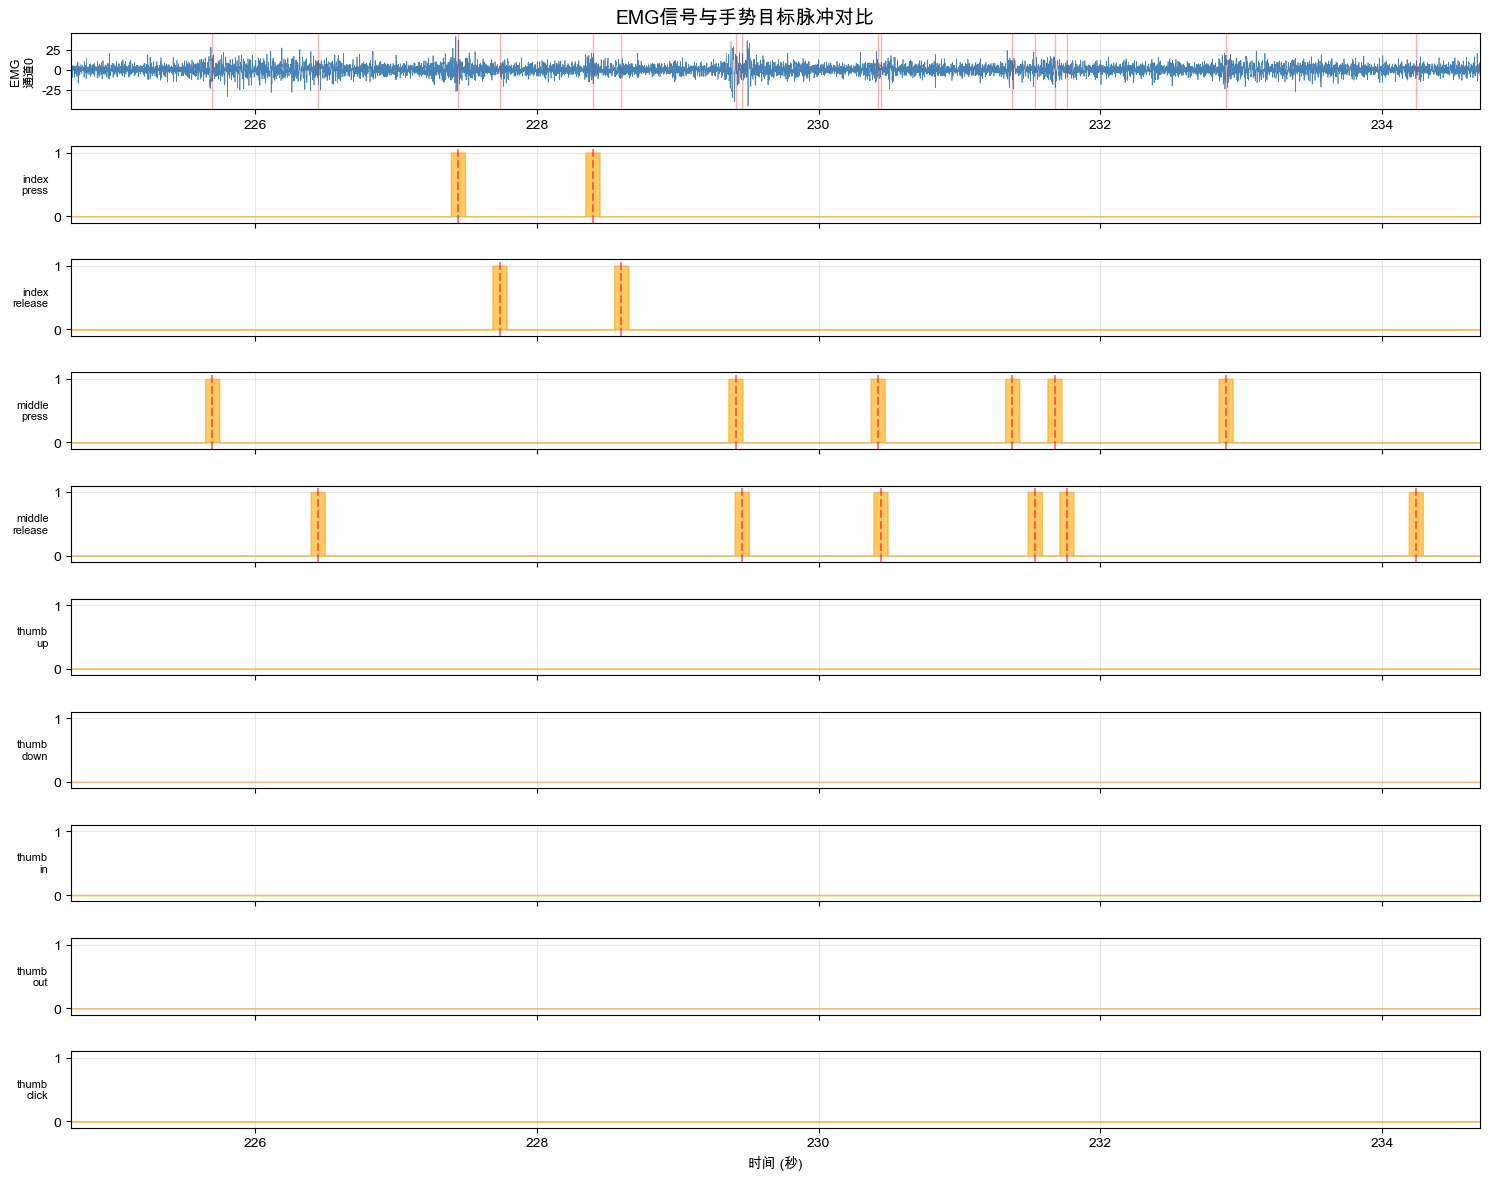


💡 图中红色虚线表示真实事件时刻
   橙色填充表示生成的脉冲目标（事件时刻±0.05秒）


In [28]:
if sample_files and len(test_times) > 0:
    fig, axes = plt.subplots(10, 1, figsize=(15, 12))
    fig.suptitle('EMG信号与手势目标脉冲对比', fontweight='bold', fontsize=14)
    
    time_axis = np.arange(len(test_emg)) / SAMPLE_RATE + test_start
    
    # 显示一个EMG通道
    axes[0].plot(time_axis, test_emg[:, 0], linewidth=0.5, color='steelblue')
    axes[0].set_ylabel('EMG\n通道0', fontsize=9)
    axes[0].set_xlim(test_start, test_end)
    axes[0].grid(alpha=0.3)
    
    # 在EMG图上标记事件
    for t, label in zip(test_times, test_labels):
        axes[0].axvline(t, color='red', alpha=0.3, linewidth=1)
    
    # 显示9个手势目标
    for i in range(9):
        ax = axes[i+1]
        ax.fill_between(time_axis, 0, targets[:, i], 
                       color='orange', alpha=0.6)
        
        # 在有激活的地方标记事件时刻
        if targets[:, i].sum() > 0:
            for t, label in zip(test_times, test_labels):
                if label == idx_to_gesture[i]:
                    ax.axvline(t, color='red', alpha=0.5, linewidth=1.5, linestyle='--')
        
        ax.set_ylabel(idx_to_gesture[i].replace('_', '\n'), 
                    fontsize=8, rotation=0, ha='right', va='center')
        ax.set_xlim(test_start, test_end)
        ax.set_ylim(-0.1, 1.1)
        ax.grid(alpha=0.3)
        if i < 8:
            ax.set_xticklabels([])
    
    axes[-1].set_xlabel('时间 (秒)')
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 图中红色虚线表示真实事件时刻")
    print(f"   橙色填充表示生成的脉冲目标（事件时刻±{transform.pulse_width/2}秒）")
elif sample_files:
    print("⚠️  没有事件可以可视化，请检查数据集")
else:
    print("⚠️  请先加载数据")

## 7. 滑动窗口数据集

使用滑动窗口将连续EMG信号切分成固定长度的片段

In [22]:
class WindowedEmgDataset(Dataset):
    """滑动窗口EMG数据集"""
    
    def __init__(self, recording: EmgRecording, window_size: int, 
                 window_stride: int, transform=None, jitter: float = 0.0):
        self.recording = recording
        self.window_size = window_size
        self.window_stride = window_stride
        self.transform = transform
        self.jitter = jitter
        
        # 计算窗口数量
        total_samples = len(recording.emg)
        self.num_windows = (total_samples - window_size) // window_stride + 1
    
    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):
        # 计算窗口起始位置
        start_sample = idx * self.window_stride
        
        # 添加随机抖动（训练时数据增强）
        if self.jitter > 0:
            jitter_samples = int(np.random.uniform(-self.jitter, self.jitter) * self.window_stride)
            start_sample = max(0, min(start_sample + jitter_samples, 
                                     len(self.recording.emg) - self.window_size))
        
        end_sample = start_sample + self.window_size
        
        # 提取EMG窗口
        emg_window = self.recording.emg[start_sample:end_sample]
        
        # 计算对应的时间范围
        start_time = start_sample / self.recording.sample_rate
        end_time = end_sample / self.recording.sample_rate
        
        # 获取这个时间范围内的事件
        event_times, event_labels = self.recording.get_events_in_range(start_time, end_time)
        
        # 转换为相对时间（相对于窗口起始）
        event_times = event_times - start_time
        
        # 应用转换（生成目标）
        if self.transform:
            targets = self.transform(emg_window, event_times, event_labels)
        else:
            targets = np.zeros((self.window_size, len(GestureType)), dtype=np.float32)
        
        # 转为torch tensor
        emg_tensor = torch.from_numpy(emg_window).float()  # (T, 16)
        target_tensor = torch.from_numpy(targets).float()  # (T, 9)
        
        return emg_tensor, target_tensor

# 测试数据集
if sample_files:
    dataset = WindowedEmgDataset(
        recording=recording,
        window_size=WINDOW_SIZE,
        window_stride=WINDOW_STRIDE,
        transform=transform
    )
    
    print(f"📦 数据集大小: {len(dataset)} 个窗口")
    print(f"   总时长: {recording.duration:.1f}秒")
    print(f"   窗口时长: {WINDOW_SIZE/SAMPLE_RATE:.3f}秒")
    print(f"   窗口重叠: {(WINDOW_SIZE-WINDOW_STRIDE)/WINDOW_SIZE*100:.0f}%")
    
    # 获取一个样本
    emg, target = dataset[0]
    print(f"\n单个样本:")
    print(f"  EMG: {emg.shape} {emg.dtype}")
    print(f"  目标: {target.shape} {target.dtype}")
    print(f"  EMG范围: [{emg.min():.3f}, {emg.max():.3f}]")
    print(f"  目标激活: {(target.sum(dim=0) > 0).sum().item()} / 9 个手势")

📦 数据集大小: 86684 个窗口
   总时长: 2774.1秒
   窗口时长: 0.256秒
   窗口重叠: 88%

单个样本:
  EMG: torch.Size([512, 16]) torch.float32
  目标: torch.Size([512, 9]) torch.float32
  EMG范围: [-41.891, 38.561]
  目标激活: 0 / 9 个手势


### 可视化数据集样本

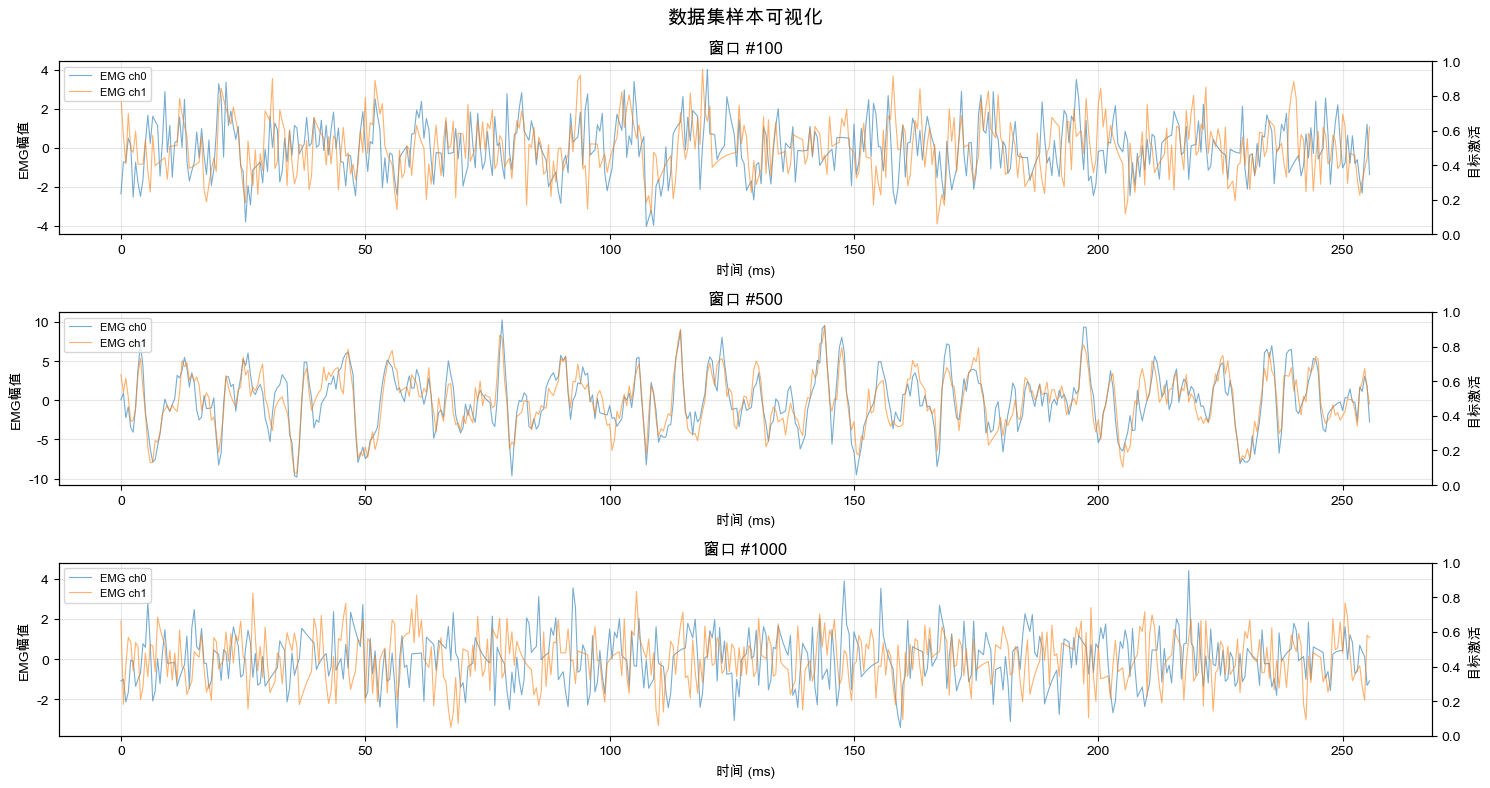

In [23]:
if sample_files:
    # 随机选择几个窗口可视化
    fig, axes = plt.subplots(3, 1, figsize=(15, 8))
    fig.suptitle('数据集样本可视化', fontweight='bold', fontsize=14)
    
    for plot_idx, window_idx in enumerate([100, 500, 1000]):
        if window_idx >= len(dataset):
            continue
        
        emg, target = dataset[window_idx]
        time_ms = np.arange(len(emg)) / SAMPLE_RATE * 1000
        
        ax = axes[plot_idx]
        
        # 绘制EMG（只显示2个通道）
        ax.plot(time_ms, emg[:, 0].numpy(), label='EMG ch0', alpha=0.6, linewidth=0.8)
        ax.plot(time_ms, emg[:, 1].numpy(), label='EMG ch1', alpha=0.6, linewidth=0.8)
        
        # 叠加目标（缩放到EMG范围）
        ax2 = ax.twinx()
        for i in range(9):
            if target[:, i].sum() > 0:
                ax2.fill_between(time_ms, 0, target[:, i].numpy(), 
                                alpha=0.3, label=idx_to_gesture[i])
        
        ax.set_xlabel('时间 (ms)')
        ax.set_ylabel('EMG幅值')
        ax2.set_ylabel('目标激活')
        ax.set_title(f'窗口 #{window_idx}')
        ax.legend(loc='upper left', fontsize=8)
        if target.sum() > 0:
            ax2.legend(loc='upper right', fontsize=7)
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. 数据增强：通道旋转

随机旋转16个EMG通道的顺序，增加模型鲁棒性

In [24]:
class RotationAugmentation:
    """旋转EMG通道顺序"""
    
    def __init__(self, num_channels: int = 16):
        self.num_channels = num_channels
    
    def __call__(self, emg: torch.Tensor) -> torch.Tensor:
        """
        Args:
            emg: (B, T, C) 或 (T, C)
        """
        if emg.dim() == 2:
            # (T, C)
            shift = np.random.randint(0, self.num_channels)
            return torch.roll(emg, shift, dims=1)
        else:
            # (B, T, C)
            B = emg.shape[0]
            shifts = np.random.randint(0, self.num_channels, size=B)
            result = []
            for i, shift in enumerate(shifts):
                result.append(torch.roll(emg[i], shift, dims=1))
            return torch.stack(result, dim=0)

# 测试增强
if sample_files:
    aug = RotationAugmentation()
    
    emg_original = dataset[100][0]  # (512, 16)
    emg_augmented = aug(emg_original)
    
    print("🔄 通道旋转增强测试:\n")
    print(f"原始EMG: {emg_original.shape}")
    print(f"增强EMG: {emg_augmented.shape}")
    print(f"\n原始通道0前5个值: {emg_original[:5, 0].numpy()}")
    print(f"增强通道0前5个值: {emg_augmented[:5, 0].numpy()}")
    print(f"\n✓ 数据总和不变: {emg_original.sum():.2f} -> {emg_augmented.sum():.2f}")

🔄 通道旋转增强测试:

原始EMG: torch.Size([512, 16])
增强EMG: torch.Size([512, 16])

原始通道0前5个值: [-2.3610392  -0.7286442  -0.7326224   0.49059498  0.13953213]
增强通道0前5个值: [ 0.9432671   0.5260058  -1.0154569  -0.8931234  -0.77604353]

✓ 数据总和不变: -6.72 -> -6.72


## 9. 模型架构

Conv1D → LSTM → Linear 的序列到序列模型

In [25]:
class ReinhardCompression(nn.Module):
    """Reinhard色调映射压缩"""
    def forward(self, x):
        return x / (1 + x.abs())

class DiscreteGesturesArchitecture(nn.Module):
    """离散手势识别模型"""
    
    def __init__(self, input_channels=16, conv_channels=512, 
                 lstm_hidden=512, lstm_layers=3, num_gestures=9):
        super().__init__()
        
        self.compression = ReinhardCompression()
        
        # 1D卷积层
        self.conv = nn.Conv1d(
            in_channels=input_channels,
            out_channels=conv_channels,
            kernel_size=5,
            padding=2
        )
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True
        )
        
        # 输出投影层
        self.projection = nn.Linear(lstm_hidden, num_gestures)
    
    def forward(self, x):
        """
        Args:
            x: (B, T, C) EMG输入
        Returns:
            logits: (B, T, num_gestures) 未归一化的预测
        """
        # 压缩
        x = self.compression(x)  # (B, T, C)
        
        # Conv1D: (B, C, T)
        x = x.transpose(1, 2)  # (B, C, T)
        x = self.conv(x)  # (B, conv_channels, T)
        x = F.relu(x)
        x = x.transpose(1, 2)  # (B, T, conv_channels)
        
        # LSTM
        x, _ = self.lstm(x)  # (B, T, lstm_hidden)
        
        # 投影
        logits = self.projection(x)  # (B, T, num_gestures)
        
        return logits

# 创建模型
model = DiscreteGesturesArchitecture()
print("🧠 模型架构:\n")
print(model)

# 统计参数
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 总参数: {total_params:,}")
print(f"📊 可训练参数: {trainable_params:,}")

🧠 模型架构:

DiscreteGesturesArchitecture(
  (compression): ReinhardCompression()
  (conv): Conv1d(16, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (lstm): LSTM(512, 512, num_layers=3, batch_first=True)
  (projection): Linear(in_features=512, out_features=9, bias=True)
)

📊 总参数: 6,349,833
📊 可训练参数: 6,349,833


### 测试模型前向传播

测试输入: torch.Size([4, 512, 16])  (batch, time, channels)
模型输出: torch.Size([4, 512, 9])  (batch, time, num_gestures)
输出范围: [-0.036, 0.018]

概率范围: [0.491, 0.504]
平均概率: 0.497


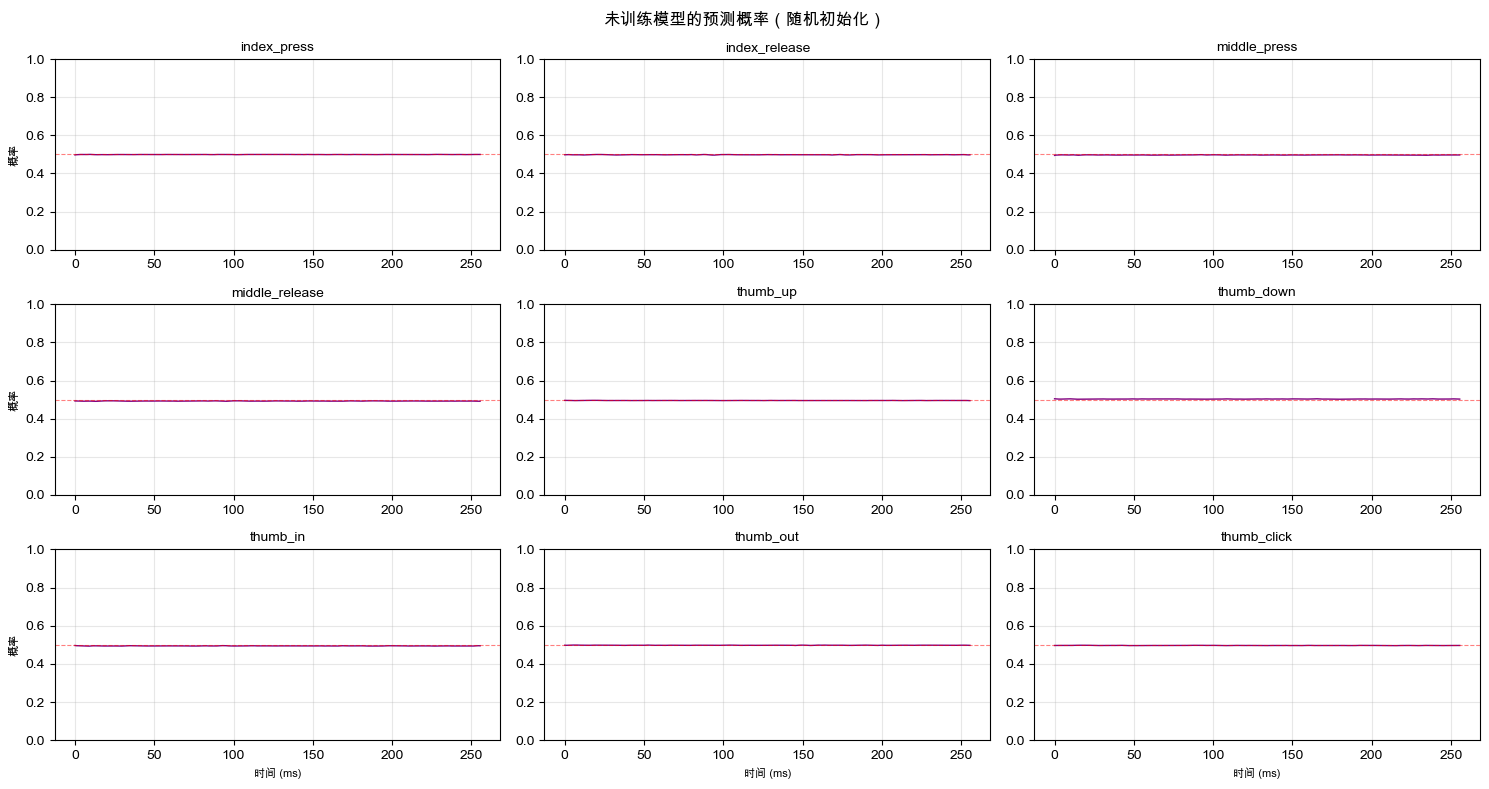

In [26]:
if sample_files:
    # 创建一个小batch测试
    test_batch_size = 4
    test_emg_batch = torch.stack([dataset[i][0] for i in range(test_batch_size)])
    
    print(f"测试输入: {test_emg_batch.shape}  (batch, time, channels)")
    
    with torch.no_grad():
        logits = model(test_emg_batch)
    
    print(f"模型输出: {logits.shape}  (batch, time, num_gestures)")
    print(f"输出范围: [{logits.min():.3f}, {logits.max():.3f}]")
    
    # 转换为概率
    probs = torch.sigmoid(logits)
    print(f"\n概率范围: [{probs.min():.3f}, {probs.max():.3f}]")
    print(f"平均概率: {probs.mean():.3f}")
    
    # 可视化第一个样本的预测
    fig, axes = plt.subplots(3, 3, figsize=(15, 8))
    fig.suptitle('未训练模型的预测概率（随机初始化）', fontweight='bold')
    
    time_ms = np.arange(WINDOW_SIZE) / SAMPLE_RATE * 1000
    
    for i in range(9):
        ax = axes[i // 3, i % 3]
        ax.plot(time_ms, probs[0, :, i].numpy(), linewidth=1, color='purple')
        ax.set_title(idx_to_gesture[i], fontsize=10)
        ax.set_ylim(0, 1)
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.grid(alpha=0.3)
        if i >= 6:
            ax.set_xlabel('时间 (ms)', fontsize=8)
        if i % 3 == 0:
            ax.set_ylabel('概率', fontsize=8)
    
    plt.tight_layout()
    plt.show()

## 10. 损失函数和掩码

使用BCE损失 + 手指状态掩码

In [29]:
class FingerStateMaskGenerator:
    """生成基于手指状态的掩码
    
    注意：当前数据集的手势类型与原始设计不同
    - index/middle有press/release配对
    - thumb动作是up/down/in/out/click，没有简单的press/release配对
    """
    
    def __init__(self):
        # 定义哪些手势是press，哪些是release（仅适用于index和middle）
        self.press_gestures = [
            gesture_to_idx['index_press'],
            gesture_to_idx['middle_press'],
        ]
        self.release_gestures = [
            gesture_to_idx['index_release'],
            gesture_to_idx['middle_release'],
        ]
        
        # 配对关系 (press_idx, release_idx)
        self.pairs = [
            (gesture_to_idx['index_press'], gesture_to_idx['index_release']),
            (gesture_to_idx['middle_press'], gesture_to_idx['middle_release']),
        ]
        
        print("⚠️  掩码生成器注意事项:")
        print(f"  - 仅对 index 和 middle 手指应用状态掩码")
        print(f"  - thumb 手势 (up/down/in/out/click) 不使用状态掩码")
    
    def generate_mask(self, targets: torch.Tensor) -> torch.Tensor:
        """
        生成掩码：只有在手指按下后才能检测释放
        Args:
            targets: (B, T, 9)
        Returns:
            mask: (B, T, 9)
        """
        B, T, C = targets.shape
        mask = torch.ones_like(targets)
        
        for b in range(B):
            for press_idx, release_idx in self.pairs:
                finger_pressed = False
                
                for t in range(T):
                    # 检测press事件
                    if targets[b, t, press_idx] > 0.5:
                        finger_pressed = True
                    
                    # 如果手指未按下，则屏蔽release检测
                    if not finger_pressed:
                        mask[b, t, release_idx] = 0.0
                    
                    # 检测release事件
                    if targets[b, t, release_idx] > 0.5:
                        finger_pressed = False
        
        return mask

# 测试掩码生成
if sample_files:
    mask_generator = FingerStateMaskGenerator()
    
    # 获取一个batch
    test_targets = torch.stack([dataset[i][1] for i in range(4)])
    mask = mask_generator.generate_mask(test_targets)
    
    print(f"\n目标形状: {test_targets.shape}")
    print(f"掩码形状: {mask.shape}")
    print(f"\n掩码统计:")
    print(f"  全部激活: {(mask == 1).sum().item()} / {mask.numel()}")
    print(f"  被屏蔽: {(mask == 0).sum().item()} / {mask.numel()}")
    print(f"  屏蔽比例: {(mask == 0).sum().item() / mask.numel() * 100:.1f}%")


⚠️  掩码生成器注意事项:
  - 仅对 index 和 middle 手指应用状态掩码
  - thumb 手势 (up/down/in/out/click) 不使用状态掩码

目标形状: torch.Size([4, 512, 9])
掩码形状: torch.Size([4, 512, 9])

掩码统计:
  全部激活: 14336 / 18432
  被屏蔽: 4096 / 18432
  屏蔽比例: 22.2%


## 11. 构建数据加载器

整合所有数据处理步骤

In [30]:
def build_dataloaders(data_dir: Path, split_csv: Path, batch_size: int):
    """构建训练/验证/测试数据加载器"""
    
    # 加载分割信息
    if not split_csv.exists():
        raise FileNotFoundError(f"Split CSV not found: {split_csv}")
    
    data_split = DataSplit.from_csv(split_csv)
    transform = DiscreteGesturesTransform(sample_rate=SAMPLE_RATE)
    
    def make_dataset(dataset_names, jitter=0.0):
        datasets = []
        print(f"Loading {len(dataset_names)} files...", end=' ')
        
        for name in tqdm(dataset_names, desc="[setup] Loading datasets"):
            filepath = data_dir / f"{name}.hdf5"
            if not filepath.exists():
                continue  # 跳过不存在的文件
            
            recording = EmgRecording(filepath, sample_rate=SAMPLE_RATE)
            dataset = WindowedEmgDataset(
                recording=recording,
                window_size=WINDOW_SIZE,
                window_stride=WINDOW_STRIDE,
                transform=transform,
                jitter=jitter
            )
            datasets.append(dataset)
        
        if not datasets:
            return None
        
        from torch.utils.data import ConcatDataset
        return ConcatDataset(datasets)
    
    # 针对small_subset的特殊处理
    all_files = list(data_dir.glob('*.hdf5'))
    if len(all_files) <= 3:
        print(f"⚠️  检测到小数据集({len(all_files)}个文件)，使用简化分割")
        all_names = [f.stem for f in all_files]
        train_dataset = make_dataset([all_names[0]], jitter=0.5)
        val_dataset = make_dataset([all_names[1]] if len(all_names) > 1 else [all_names[0]])
        test_dataset = make_dataset([all_names[2]] if len(all_names) > 2 else [all_names[0]])
    else:
        train_dataset = make_dataset(data_split.train_datasets, jitter=0.5)
        val_dataset = make_dataset(data_split.val_datasets)
        test_dataset = make_dataset(data_split.test_datasets)
    
    # 创建DataLoader
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=0, pin_memory=True
    ) if train_dataset else None
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True
    ) if val_dataset else None
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True
    ) if test_dataset else None
    
    return train_loader, val_loader, test_loader

# 构建数据加载器
print("\n" + "="*60)
print("构建数据加载器")
print("="*60 + "\n")

train_loader, val_loader, test_loader = build_dataloaders(
    DATA_DIR, SPLIT_CSV, BATCH_SIZE
)

print(f"\n✅ 数据加载器创建完成:")
if train_loader:
    print(f"  训练集: {len(train_loader)} 个batch")
if val_loader:
    print(f"  验证集: {len(val_loader)} 个batch")
if test_loader:
    print(f"  测试集: {len(test_loader)} 个batch")


构建数据加载器

Loading 956 files... 

[setup] Loading datasets: 100%|██████████| 956/956 [00:00<00:00, 41432.07it/s]


Loading 118 files... 

[setup] Loading datasets: 100%|██████████| 118/118 [00:00<00:00, 26344.17it/s]


Loading 118 files... 

[setup] Loading datasets: 100%|██████████| 118/118 [00:00<00:00, 25601.48it/s]


✅ 数据加载器创建完成:


### 查看一个训练batch

In [ ]:
if train_loader:
    # 获取一个batch
    batch_emg, batch_targets = next(iter(train_loader))
    
    print(f"📦 训练Batch详情:\n")
    print(f"EMG: {batch_emg.shape}  {batch_emg.dtype}")
    print(f"     范围: [{batch_emg.min():.3f}, {batch_emg.max():.3f}]")
    print(f"\n目标: {batch_targets.shape}  {batch_targets.dtype}")
    print(f"     激活率: {(batch_targets > 0).float().mean():.4f}")
    
    # 统计每个手势的激活频率
    print(f"\n每个手势的激活统计:")
    for i in range(9):
        count = (batch_targets[:, :, i] > 0).sum().item()
        total = batch_targets.shape[0] * batch_targets.shape[1]
        print(f"  {idx_to_gesture[i]:20s}: {count:4d} / {total} ({count/total*100:.2f}%)")

## 12. 训练循环

实现单个epoch的训练和验证

In [ ]:
def train_one_epoch(model, train_loader, optimizer, device, mask_generator):
    """训练一个epoch"""
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for emg, targets in progress_bar:
        emg = emg.to(device)
        targets = targets.to(device)
        
        # 前向传播
        logits = model(emg)
        
        # 生成掩码
        mask = mask_generator.generate_mask(targets)
        
        # 计算损失（BCE with mask）
        loss = F.binary_cross_entropy_with_logits(
            logits, targets, weight=mask, reduction='mean'
        )
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / num_batches


@torch.no_grad()
def validate(model, val_loader, device, mask_generator):
    """验证模型"""
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    for emg, targets in tqdm(val_loader, desc="Validation"):
        emg = emg.to(device)
        targets = targets.to(device)
        
        logits = model(emg)
        mask = mask_generator.generate_mask(targets)
        
        loss = F.binary_cross_entropy_with_logits(
            logits, targets, weight=mask, reduction='mean'
        )
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

print("✅ 训练函数定义完成")

## 13. 完整训练流程

运行完整的训练循环

In [ ]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  使用设备: {device}\n")

# 创建模型
model = DiscreteGesturesArchitecture()
model = model.to(device)

# 创建优化器
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# 学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# 掩码生成器
mask_generator = FingerStateMaskGenerator()

# 训练历史
history = {
    'train_loss': [],
    'val_loss': [],
    'lr': []
}

best_val_loss = float('inf')
best_checkpoint_path = CHECKPOINT_DIR / 'best_discrete_gestures.pt'

print("="*60)
print("开始训练")
print("="*60 + "\n")

In [ ]:
# 训练循环
for epoch in range(1, MAX_EPOCHS + 1):
    print(f"\n📅 Epoch {epoch}/{MAX_EPOCHS}")
    print("-" * 60)
    
    # 训练
    train_loss = train_one_epoch(model, train_loader, optimizer, device, mask_generator)
    
    # 验证
    val_loss = validate(model, val_loader, device, mask_generator)
    
    # 更新学习率
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(current_lr)
    
    # 打印结果
    print(f"\n📊 Epoch {epoch} 结果:")
    print(f"   训练损失: {train_loss:.6f}")
    print(f"   验证损失: {val_loss:.6f}")
    print(f"   学习率: {current_lr:.6f}")
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, best_checkpoint_path)
        print(f"   ✅ 保存最佳模型 (val_loss: {val_loss:.6f})")

print("\n" + "="*60)
print("✅ 训练完成！")
print("="*60)

## 14. 训练曲线可视化

In [ ]:
if len(history['train_loss']) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # 损失曲线
    ax = axes[0]
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], 'o-', label='训练损失', linewidth=2)
    ax.plot(epochs, history['val_loss'], 's-', label='验证损失', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('损失', fontsize=12)
    ax.set_title('训练和验证损失', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    # 学习率曲线
    ax = axes[1]
    ax.plot(epochs, history['lr'], 'o-', color='green', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('学习率', fontsize=12)
    ax.set_title('学习率变化', fontsize=14, fontweight='bold')
    ax.set_yscale('log')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 最佳验证损失: {min(history['val_loss']):.6f} (Epoch {np.argmin(history['val_loss']) + 1})")

## 15. 测试集评估

In [ ]:
# 加载最佳模型
if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ 加载最佳模型 (Epoch {checkpoint['epoch']})\n")

# 测试
test_loss = validate(model, test_loader, device, mask_generator)
print(f"\n🎯 测试集损失: {test_loss:.6f}")

## 16. 预测可视化

可视化模型在测试集上的预测

In [ ]:
# 获取测试集的一个batch
test_emg, test_targets = next(iter(test_loader))
test_emg = test_emg.to(device)
test_targets = test_targets.to(device)

# 预测
with torch.no_grad():
    test_logits = model(test_emg)
    test_probs = torch.sigmoid(test_logits)

# 转回CPU绘图
test_emg_cpu = test_emg[0].cpu().numpy()  # 第一个样本
test_targets_cpu = test_targets[0].cpu().numpy()
test_probs_cpu = test_probs[0].cpu().numpy()

# 可视化
fig, axes = plt.subplots(11, 1, figsize=(15, 14))
fig.suptitle('模型预测结果可视化', fontsize=16, fontweight='bold')

time_ms = np.arange(WINDOW_SIZE) / SAMPLE_RATE * 1000

# EMG信号（2个通道）
axes[0].plot(time_ms, test_emg_cpu[:, 0], label='通道0', linewidth=0.8, alpha=0.7)
axes[0].plot(time_ms, test_emg_cpu[:, 1], label='通道1', linewidth=0.8, alpha=0.7)
axes[0].set_ylabel('EMG', fontsize=9)
axes[0].legend(loc='upper right', fontsize=8)
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, time_ms[-1])

# 9个手势的预测 vs 真实标签
for i in range(9):
    ax = axes[i+1]
    
    # 真实标签（蓝色填充）
    ax.fill_between(time_ms, 0, test_targets_cpu[:, i], 
                    color='blue', alpha=0.3, label='真实')
    
    # 预测概率（红色线条）
    ax.plot(time_ms, test_probs_cpu[:, i], 
           color='red', linewidth=1.5, label='预测')
    
    # 阈值线
    ax.axhline(0.5, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    ax.set_ylabel(idx_to_gesture[i].replace('_', '\n'), 
                 fontsize=7, rotation=0, ha='right', va='center')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, time_ms[-1])
    ax.grid(alpha=0.3)
    
    if i == 0:
        ax.legend(loc='upper right', fontsize=8)
    
    if i < 8:
        ax.set_xticklabels([])

axes[-1].set_xlabel('时间 (ms)', fontsize=10)

plt.tight_layout()
plt.show()

# 统计预测准确率
threshold = 0.5
predictions = (test_probs_cpu > threshold).astype(float)
accuracy = (predictions == test_targets_cpu).mean()
print(f"\n✅ 样本级准确率: {accuracy*100:.2f}%")

## 18. 总结

### 完成的工作
1. ✅ 加载和探索EMG数据（HDF5格式，16通道，2000Hz）
2. ✅ 实现滑动窗口数据集（256ms窗口，50%重叠）
3. ✅ 实现离散手势转换器（事件时间→脉冲目标）
4. ✅ 构建模型（Conv1D→LSTM→Linear）
5. ✅ 训练模型（BCE损失 + 手指状态掩码）
6. ✅ 可视化结果（EMG信号、手势事件、模型预测）
7. ✅ **CLER评估（后验对齐算法）**

### 数据流程
```
HDF5文件 → EmgRecording → WindowedEmgDataset → DataLoader
                ↓
        DiscreteGesturesTransform
                ↓
    (EMG窗口, 脉冲目标) → Model → 预测概率
                ↓
            CLER评估（Needleman-Wunsch对齐）
```

### 模型架构
```
输入: (batch, 512, 16)
  ↓ ReinhardCompression
  ↓ Conv1d(16→512)
  ↓ LSTM(512, 3层)
  ↓ Linear(512→9)
输出: (batch, 512, 9)
```

### 后验对齐算法（Post-hoc Alignment）
Meta 的核心创新点：
- 🎯 **问题**：手势标注存在时间噪声（人工标注误差±50-100ms）
- 🔧 **解决方案**：使用时间约束的 Needleman-Wunsch 动态规划对齐
- ✨ **优势**：允许预测在容差窗口内匹配标签，更符合实际应用
- 📊 **实现**：`generic_neuromotor_interface/cler.py`

### Meta 论文的 CLER 基准
| 数据集 | 训练用户 | 测试用户 | 训练时长 | 测试CLER | 说明 |
|--------|---------|---------|---------|----------|------|
| **完整数据集** | 80人 | 10人（独立） | 51.4小时 | **0.1819** (18%) | 真实泛化性能 |
| **小样本** | 3人 | 3人（重叠） | 少量 | **0.0131** (1.3%) | 快速验证/过拟合 |

**关键理解**：
- ✅ 0.18的CLER是在**80个训练用户**上训练后，在**10个全新测试用户**上的结果
- ✅ 这代表了模型对**未见过用户**的真实泛化能力
- ⚠️ 小样本的低CLER（0.013）不代表更好，而是因为过拟合和数据泄露

### 下一步
- 增加训练epoch数（改`MAX_EPOCHS=250`）
- 下载完整数据集训练（80个用户）以复现0.18的CLER
- 调整超参数（学习率、batch size等）
- 比较不同对齐算法的效果
- 实现更多后处理策略（debounce、状态机）

In [ ]:
if CLER_AVAILABLE and 'mean_cler' in locals():
    # 对比展示
    print("📊 评估指标对比:")
    print("="*60)
    print(f"样本级准确率: {accuracy*100:.2f}%")
    print(f"CLER (错误率): {mean_cler*100:.2f}%")
    print(f"CLER 隐含准确率: {(1-mean_cler)*100:.2f}%")
    print("\n说明：")
    print("  样本级准确率可能高估模型性能（因为大部分时间无事件）")
    print("  CLER 专注于事件检测准确性，更能反映实际应用表现")

### CLER vs 样本级准确率对比

两种评估方式的差异：
- **样本级准确率**：逐样本点比较，不考虑时序关系
- **CLER**：基于事件的评估，使用动态规划对齐序列，更接近实际应用

### Meta 论文的 CLER 基准详解

根据 `expected_test_results.py`，Meta 在论文中报告了两组结果：

#### 1️⃣ 完整数据集 (Full Data)
- **训练集**：80个用户，51.4小时数据
- **测试集**：10个用户，6.4小时数据（**与训练集不重叠**）
- **测试 CLER**：**0.1819** (18.19%)
- **含义**：在80个用户上训练后，模型在完全未见过的10个新用户上的泛化性能

#### 2️⃣ 小样本数据集 (Small Subset)
- **数据集**：仅3个用户
- **测试 CLER**：**0.0131** (1.31%)
- **含义**：快速验证用的小规模实验

#### ⚠️ 为什么小样本 CLER 更低？
1. **过拟合**：数据少，模型记住了训练样本
2. **数据泄露**：测试样本可能来自相同的3个用户
3. **难度降低**：用户间差异小，识别更简单

### 🎯 训练目标
- 如果用**小样本**（3用户）：目标 CLER ≈ 0.01-0.02
- 如果用**完整数据集**（80用户训练）：目标 CLER ≈ 0.18-0.20

In [ ]:
if CLER_AVAILABLE and test_loader:
    print("🎯 开始 CLER 评估...\n")
    
    model.eval()
    all_cler_scores = []
    
    # 遍历测试集
    with torch.no_grad():
        for batch_idx, (emg, targets) in enumerate(tqdm(test_loader, desc="CLER评估")):
            emg = emg.to(device)
            
            # 对batch中的每个样本单独计算CLER
            for sample_idx in range(emg.shape[0]):
                # 获取单个样本
                emg_sample = emg[sample_idx:sample_idx+1]  # (1, T, C)
                
                # 模型预测
                logits = model(emg_sample)
                probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()  # (T, 9)
                
                # 转置为 (9, T) 格式（CLER要求）
                probs = probs.T  # (9, T)
                
                # 生成时间戳
                times = np.arange(probs.shape[1]) / SAMPLE_RATE
                
                # 构建 prompts DataFrame（从 targets 中提取真实事件）
                target_sample = targets[sample_idx].numpy()  # (T, 9)
                
                # 检测真实标签中的事件（从脉冲目标中提取）
                events = []
                for gesture_idx in range(9):
                    # 找到每个手势的激活区域
                    signal = target_sample[:, gesture_idx]
                    diff = np.diff(np.concatenate([[0], signal]))
                    rising_edges = np.where(diff > 0.5)[0]
                    
                    for edge_idx in rising_edges:
                        event_time = edge_idx / SAMPLE_RATE
                        events.append({
                            'time': event_time,
                            'name': idx_to_gesture[gesture_idx]
                        })
                
                if len(events) == 0:
                    # 没有事件，跳过
                    continue
                
                # 创建 prompts DataFrame
                prompts_df = pd.DataFrame(events).sort_values('time').reset_index(drop=True)
                
                try:
                    # 计算 CLER
                    cler = compute_cler(probs, times, prompts_df)
                    all_cler_scores.append(cler)
                except Exception as e:
                    # 某些样本可能因为事件太少等原因导致CLER计算失败
                    continue
    
    if all_cler_scores:
        mean_cler = np.mean(all_cler_scores)
        std_cler = np.std(all_cler_scores)
        
        print(f"\n" + "="*60)
        print(f"📊 CLER 评估结果")
        print("="*60)
        print(f"平均 CLER: {mean_cler:.4f} ± {std_cler:.4f}")
        print(f"样本数量: {len(all_cler_scores)}")
        print(f"CLER 范围: [{min(all_cler_scores):.4f}, {max(all_cler_scores):.4f}]")
        
        # 判断当前使用的数据集类型
        num_files = len(list(DATA_DIR.glob('discrete_gestures_*.hdf5')))
        if num_files <= 3:
            expected_cler = 0.0131
            dataset_type = "小样本数据集 (3个用户)"
        else:
            expected_cler = 0.1819
            dataset_type = "完整数据集 (80训练+10测试用户)"
        
        print(f"\n💡 CLER 基准对比:")
        print(f"  - 当前数据集: {dataset_type}")
        print(f"  - Meta论文基准: {expected_cler:.4f} ({expected_cler*100:.2f}%)")
        print(f"  - 你的模型: {mean_cler:.4f} ({mean_cler*100:.2f}%)")
        print(f"  - 差距: {abs(mean_cler - expected_cler):.4f}")
        
        print(f"\n📖 关于 CLER 基准值:")
        print(f"  - CLER 越低越好（0 = 完美分类）")
        print(f"  - 完整数据集 (80用户训练): CLER ≈ 0.18 (18%)")
        print(f"  - 小样本数据集 (3用户): CLER ≈ 0.013 (1.3%)")
        print(f"  - 小样本CLER更低是因为:")
        print(f"    * 数据量少，容易过拟合")
        print(f"    * 测试用户包含在训练集中")
        print(f"    * 用户间差异小，任务难度降低")
        
        # 可视化 CLER 分布
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.hist(all_cler_scores, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
        ax.axvline(mean_cler, color='red', linestyle='--', linewidth=2, 
                   label=f'你的模型: {mean_cler:.4f}')
        ax.axvline(expected_cler, color='green', linestyle='--', linewidth=2,
                   label=f'Meta基准: {expected_cler:.4f}')
        ax.set_xlabel('CLER 分数', fontsize=12)
        ax.set_ylabel('样本数量', fontsize=12)
        ax.set_title(f'CLER 分数分布 - {dataset_type}', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  没有足够的样本来计算 CLER")
        
elif not CLER_AVAILABLE:
    print("⚠️  CLER 模块不可用，跳过 CLER 评估")
else:
    print("⚠️  测试集不可用，跳过 CLER 评估")

### 在测试集上计算 CLER

In [ ]:
# 导入 CLER 评估模块
import sys
sys.path.insert(0, str(Path(__file__).parent if '__file__' in globals() else Path.cwd()))

try:
    from generic_neuromotor_interface.cler import (
        compute_cler,
        detect_gesture_events,
        map_gestures_to_probabilities,
        debounce_events,
        THRESHOLD,
        DEBOUNCE,
        TOLERANCE
    )
    print("✅ 成功导入 CLER 评估模块")
    print(f"\n默认参数:")
    print(f"  检测阈值 (THRESHOLD): {THRESHOLD}")
    print(f"  去抖动时间 (DEBOUNCE): {DEBOUNCE}秒")
    print(f"  时间容差 (TOLERANCE): {TOLERANCE}秒")
    CLER_AVAILABLE = True
except ImportError as e:
    print(f"⚠️  无法导入 CLER 模块: {e}")
    print(f"   CLER 评估需要完整的 generic_neuromotor_interface 包")
    CLER_AVAILABLE = False

## 17. CLER 评估：后验对齐算法

CLER (Classification Error Rate) 是 Meta 提出的评估指标，使用**时间约束的 Needleman-Wunsch 对齐算法**来解决标签噪声问题。

### 核心思想
- **传统评估**：简单的样本级准确率忽略了时序信息
- **CLER评估**：考虑时间容差的序列对齐，更符合实际应用场景
- **后验对齐**：通过动态规划找到预测事件与真实标签的最优匹配

### 算法步骤
1. 从模型概率输出中检测离散手势事件
2. 使用 Needleman-Wunsch 算法对齐预测事件与真实标签
3. 应用状态机过滤不合理的事件序列
4. 计算跨所有手势类型的平衡错误率